## Introduction

The purpose of this notebook is to repeat the functional linear regression analysis found in notebooks 1-3 on a slightly noisier data set.

## TODO: change remarks

## Imports

In [1]:
from IPython.display import Image
import os
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tecatorfda.data import (
    generate_and_load_tecator_data_iid_noise,
    load_tecator_fat,
)

## Generate slightly noisy data ($\alpha = 0.05$)

We add independent Gaussian noise to the wavelength data via columnwise standard deviations multiplied by some $\alpha$.

In [2]:
project_root = Path.cwd().resolve().parent
original_data_directory = project_root / "data" / "original"
noisy_data_directory = project_root / "data" / "04_noisy_005"

noisy_data = generate_and_load_tecator_data_iid_noise(
    original_data_location=original_data_directory,
    new_data_location=noisy_data_directory,
    alpha=0.05,
    random_seed=0,
)

## Run 3 scripts on the noisy data

Run the following scripts:
1. `scripts/01_ols.py`
2. `scripts/02_ridge.py`
3. `scripts/03_flr.py`

Expect them to run for a few minutes.

In [3]:
# Define the data directory to save to.
artifacts_location_directory = project_root / "artifacts" / "04_noisy_data_005"
output_directory_1 = artifacts_location_directory / "01_ols"
output_directory_2 = artifacts_location_directory / "02_ridge"
output_directory_3 = artifacts_location_directory / "03_flr"

# Define the data directories to read from.
data_location_directory = noisy_data_directory

%run ../scripts/01_ols.py --out-dir "{output_directory_1}" --data-location-directory "{noisy_data_directory}"
%run ../scripts/02_ridge.py --out-dir "{output_directory_2}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"
%run ../scripts/03_flr.py --out-dir "{output_directory_3}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"

162/1620 runs (10%) | elapsed 5.9s
324/1620 runs (20%) | elapsed 10.9s
486/1620 runs (30%) | elapsed 16.7s
648/1620 runs (40%) | elapsed 23.8s
810/1620 runs (50%) | elapsed 31.0s
972/1620 runs (60%) | elapsed 40.2s
1134/1620 runs (70%) | elapsed 47.7s
1296/1620 runs (80%) | elapsed 56.0s
1458/1620 runs (90%) | elapsed 67.7s
1620/1620 runs (100%) | elapsed 80.2s
Done with analysis plot generation! Proceding to repeated CV.


## EDA

### Visualize the first 5 wavelength spectra with the mean functional

In [4]:
tecator_df, fat_df, wavelength_grid, wavelength_unit = load_tecator_fat(location=data_location_directory)

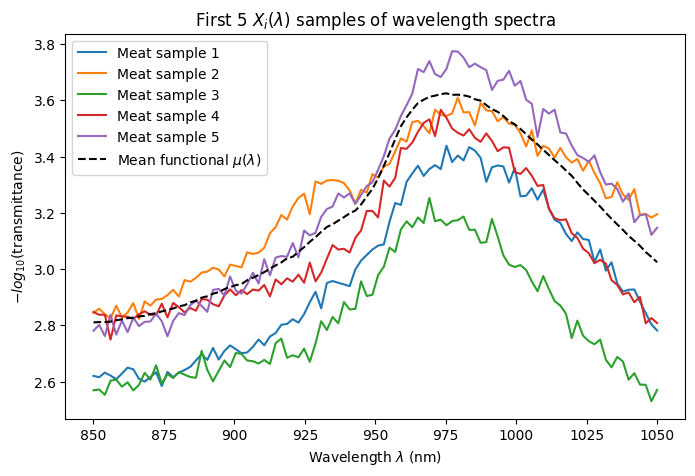

In [5]:
plt.figure(figsize=(8,5))

for i in range(5):
    plt.plot(wavelength_grid, tecator_df.iloc[i], label=f"Meat sample {i+1}")

plt.plot(wavelength_grid, tecator_df.mean(axis=0), linestyle="--", c="black", label=r"Mean functional $\mu(\lambda)$")

plt.title(r"First 5 $X_{i}(\lambda)$ samples of wavelength spectra")
plt.xlabel(rf"Wavelength $\lambda$ ({wavelength_unit})")
plt.ylabel(r"$-log_{10}(\text{transmittance})$")
plt.legend()
plt.show()

## OLS

### Load the results

In [6]:
all_ols_names = ["ols_full", "ols_0_train", "ols_0_test", "ols_42_train", "ols_42_test", "ols_cv"]

all_results = {}

for name in all_ols_names:
    with open(str((output_directory_1 / "results" / (name + ".pkl"))), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/artifacts/01_ols.
        all_results[name] = pickle.load(f)

### Full data diagnostics

The data consist of 215 functional $X(t)$ samples, each observed on a finite grid of 100 wavelength values. This notebook deals with the discretized approach, where we treat these data as a $215 \times 100$ multivariate data set. There are many qualities of the data we can examine before looking at the linear fits, and we focus on correlations among variables, multicollinearity, and leverage and influential points.

#### Correlation and multicollinearity

We display a correlation matrix heatmap for the data.

Maximum correlation: 1.0
Minimum correlation: 0.9594


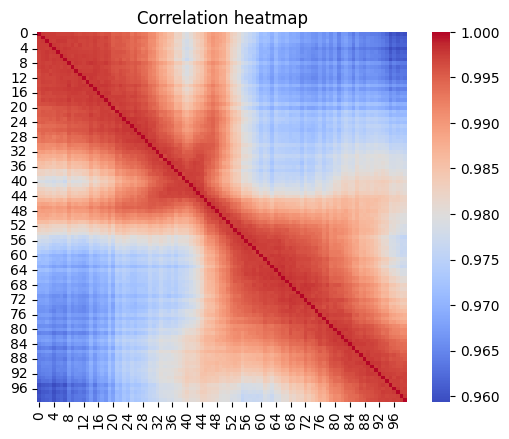

In [7]:
corr_matrix = np.corrcoef(all_results["ols_full"].X.T)
print("Maximum correlation:", corr_matrix.max())
print("Minimum correlation:", round(corr_matrix.min(), 4))

sns.heatmap(np.corrcoef(all_results["ols_full"].X.T), cmap="coolwarm", square=True)
plt.title("Correlation heatmap")
plt.show()

Note how every pair of variables has extremely high correlation. We choose to plot even those with 0.96 correlation in blue above to highlight the nontrivial structure that appears; notice that all early observations have almost perfect correlation with the middle of the domain.

Just as a point of interest, let's look at the multicollinearity of the fit. The condition number is the ratio of largest to smallest eigenvalues of $X'X$; high condition number implies that inversion of this matrix (which is exactly what we do in linear regression) can be sensitive to small changes in inputs.

In [8]:
print("Condition number of linear fit to full data:", round(all_results["ols_full"].condition_number, 2))

Condition number of linear fit to full data: 16774744.18


This is astronomically greater than 1000, so we have sigificant multicollinearity, as expected for functional data sampled on a fine grid.

#### Leverage

What do the leverage scores for the data look like? These can be easily computed as the diagonal elements of the hat matrix $X(X'X)^{-1}X'$, and they suggest which observations may greatly influence the linear regression coefficients. Typically, we identify high leverage as greater than $\frac{2p}{n}$, where $n$ is the number of samples and $p$ is the number of predictors.

High leverage boundary: 0.93


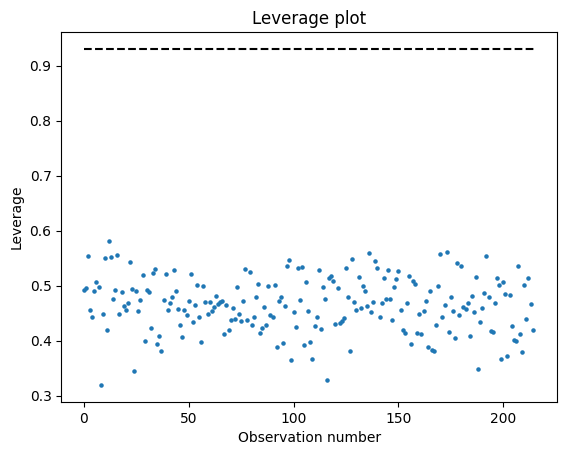

In [9]:
leverage_scores = all_results["ols_full"].leverage_scores
n, p = all_results["ols_full"].X.shape
print("High leverage boundary:", round(2*p/n, 2))

plt.scatter(list(range(len(leverage_scores))), leverage_scores, s=5)
plt.plot([0, len(leverage_scores)], [2*p/n, 2*p/n], c="black", linestyle="--")
plt.title("Leverage plot")
plt.xlabel("Observation number")
plt.ylabel("Leverage")

plt.show()

We can see that there are 7-8 high leverage samples! Leverage tells us how far a sample's regressor values are from the mean, but we also want to see how much each sample will influence a linear fit. Before moving to influential point discovery, we show plots for the linear fit to the entire data set.

#### Fit plots

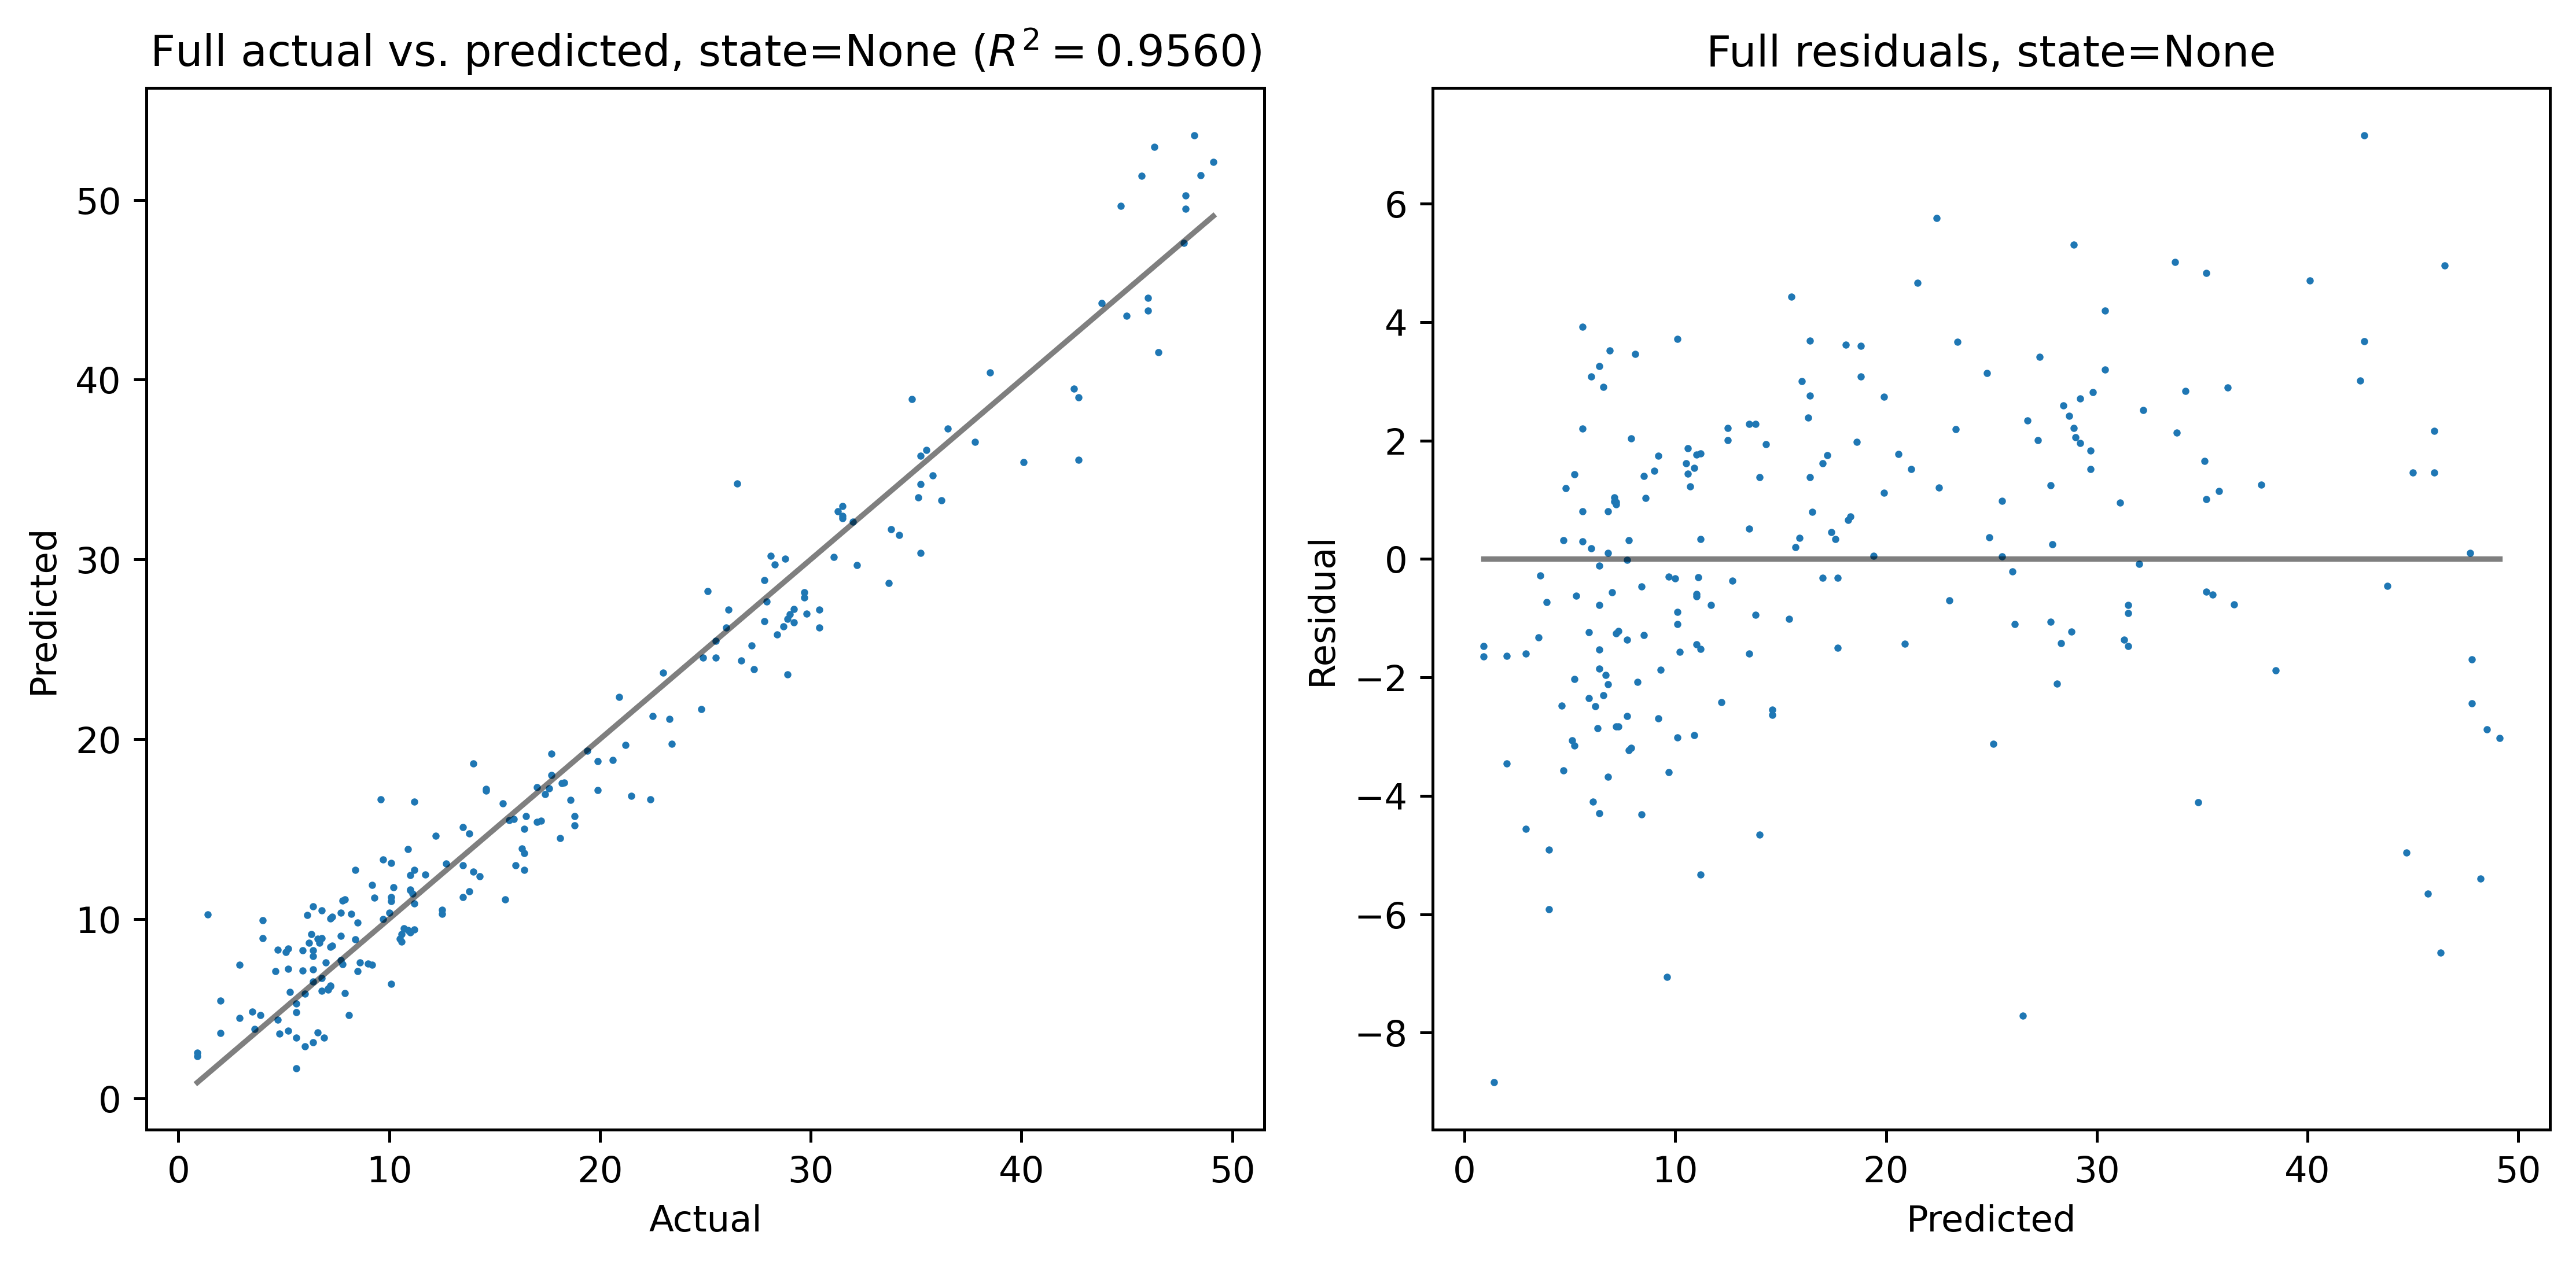

In [11]:
Image(filename="../artifacts/04_noisy_data_005/01_ols/plots/ols_full.png")

#### Influential points (TODO)

To examine influence of each point on the linear fit, we plot leverages against the standardized residuals.

In [ ]:
"""sigma2 = np.sum((all_results["ols_full"].y - all_results["ols_full"].predicted)**2) / (n-p)
standardized_residuals = (all_results["ols_full"].y - all_results["ols_full"].predicted).flatten() / np.sqrt(sigma2 * (1 - leverage_scores))

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(leverage_scores, standardized_residuals.flatten(), alpha=0.7)

ax.axhline(0, color="black", linewidth=1)
ax.axhline(2, linestyle="--", color="gray")
ax.axhline(-2, linestyle="--", color="gray")

ax.set_xlabel("Leverage")
ax.set_ylabel("Standardized Residuals")
ax.set_title("Residuals vs Leverage")

def cooks_contour(D, leverage, p):
    return np.sqrt(D * p * (1 - leverage) / leverage)

h_vals = np.linspace(leverage_scores.min() + 1e-4, leverage_scores.max(), 100)

for D in [0.5, 1]:
    r = cooks_contour(D, h_vals, p)
    ax.plot(h_vals, r, linestyle="--", color="red")
    ax.plot(h_vals, -r, linestyle="--", color="red")
    ax.text(h_vals[-1], r[-1], f"D={D}", color="red")


plt.tight_layout()
plt.show()
"""

There doesn't seem to be a clear pattern in the residuals, which suggests the linear model captures the behavior of the data. However, due to the significant multicollinearity and presence of influential points, we have reason to attempt our other methods. However, let's examine OLS regression on a holdout set, first.

### Holdout set diagnostics

#### Fit plots

First, let's use `random_state = 0`. Like above, we examine actual vs. predicted and residual plots.

Train:

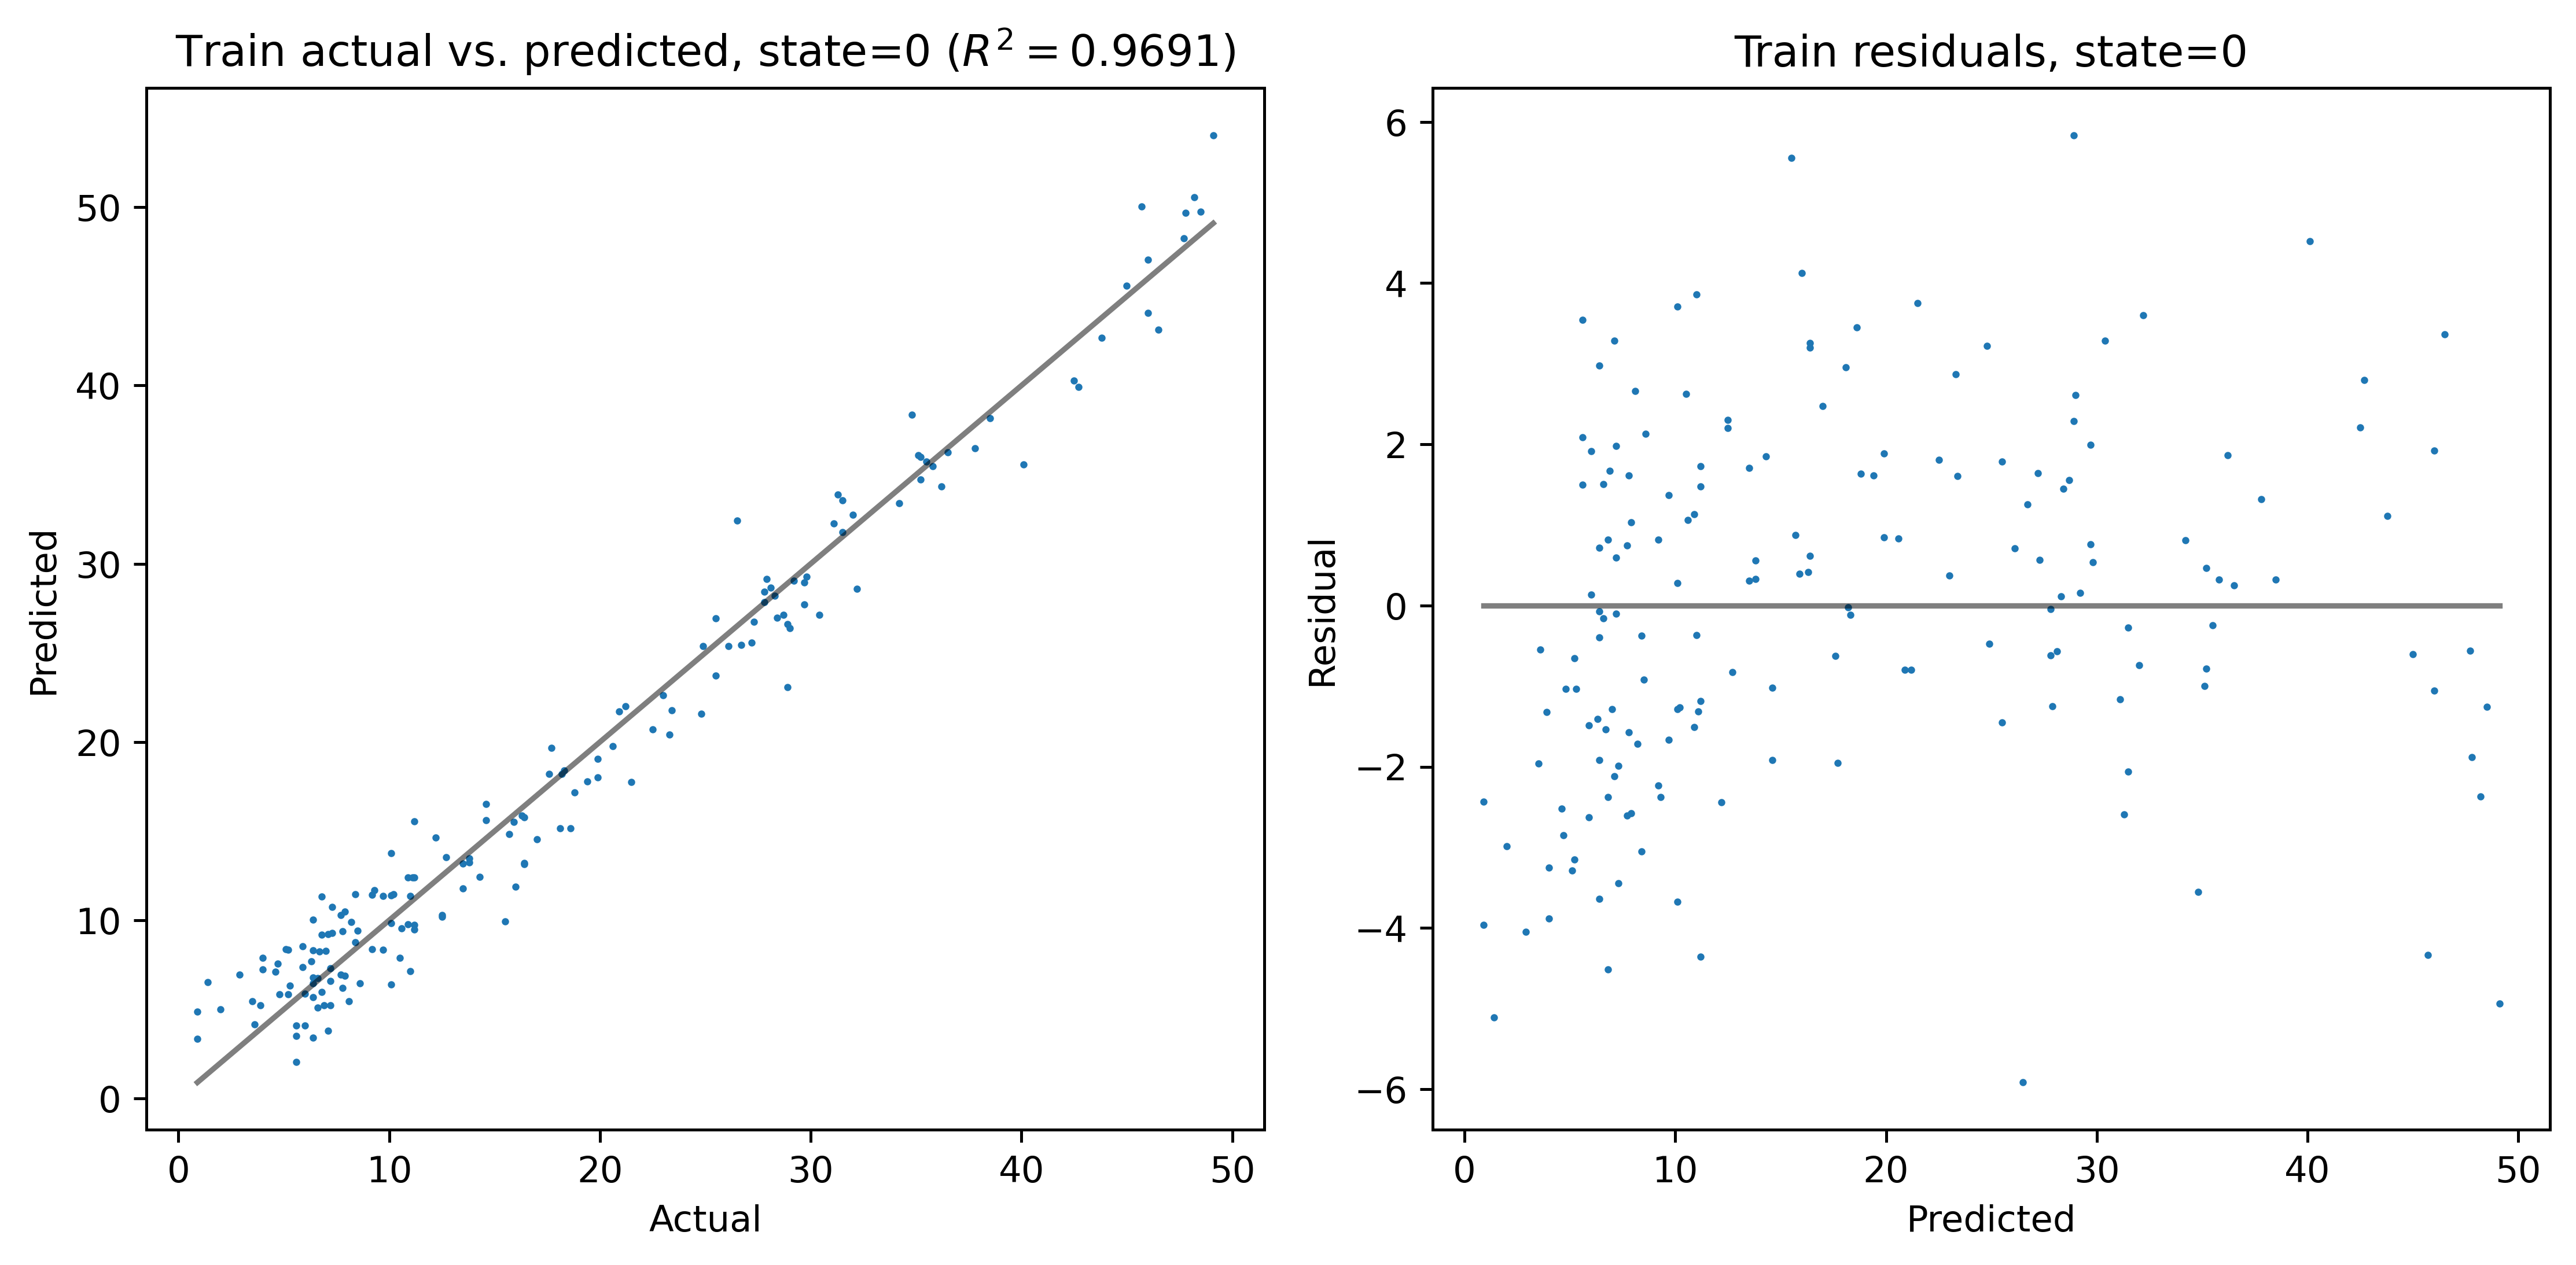

In [12]:
Image(filename="../artifacts/04_noisy_data_005/01_ols/plots/ols_0_train.png")

Test:

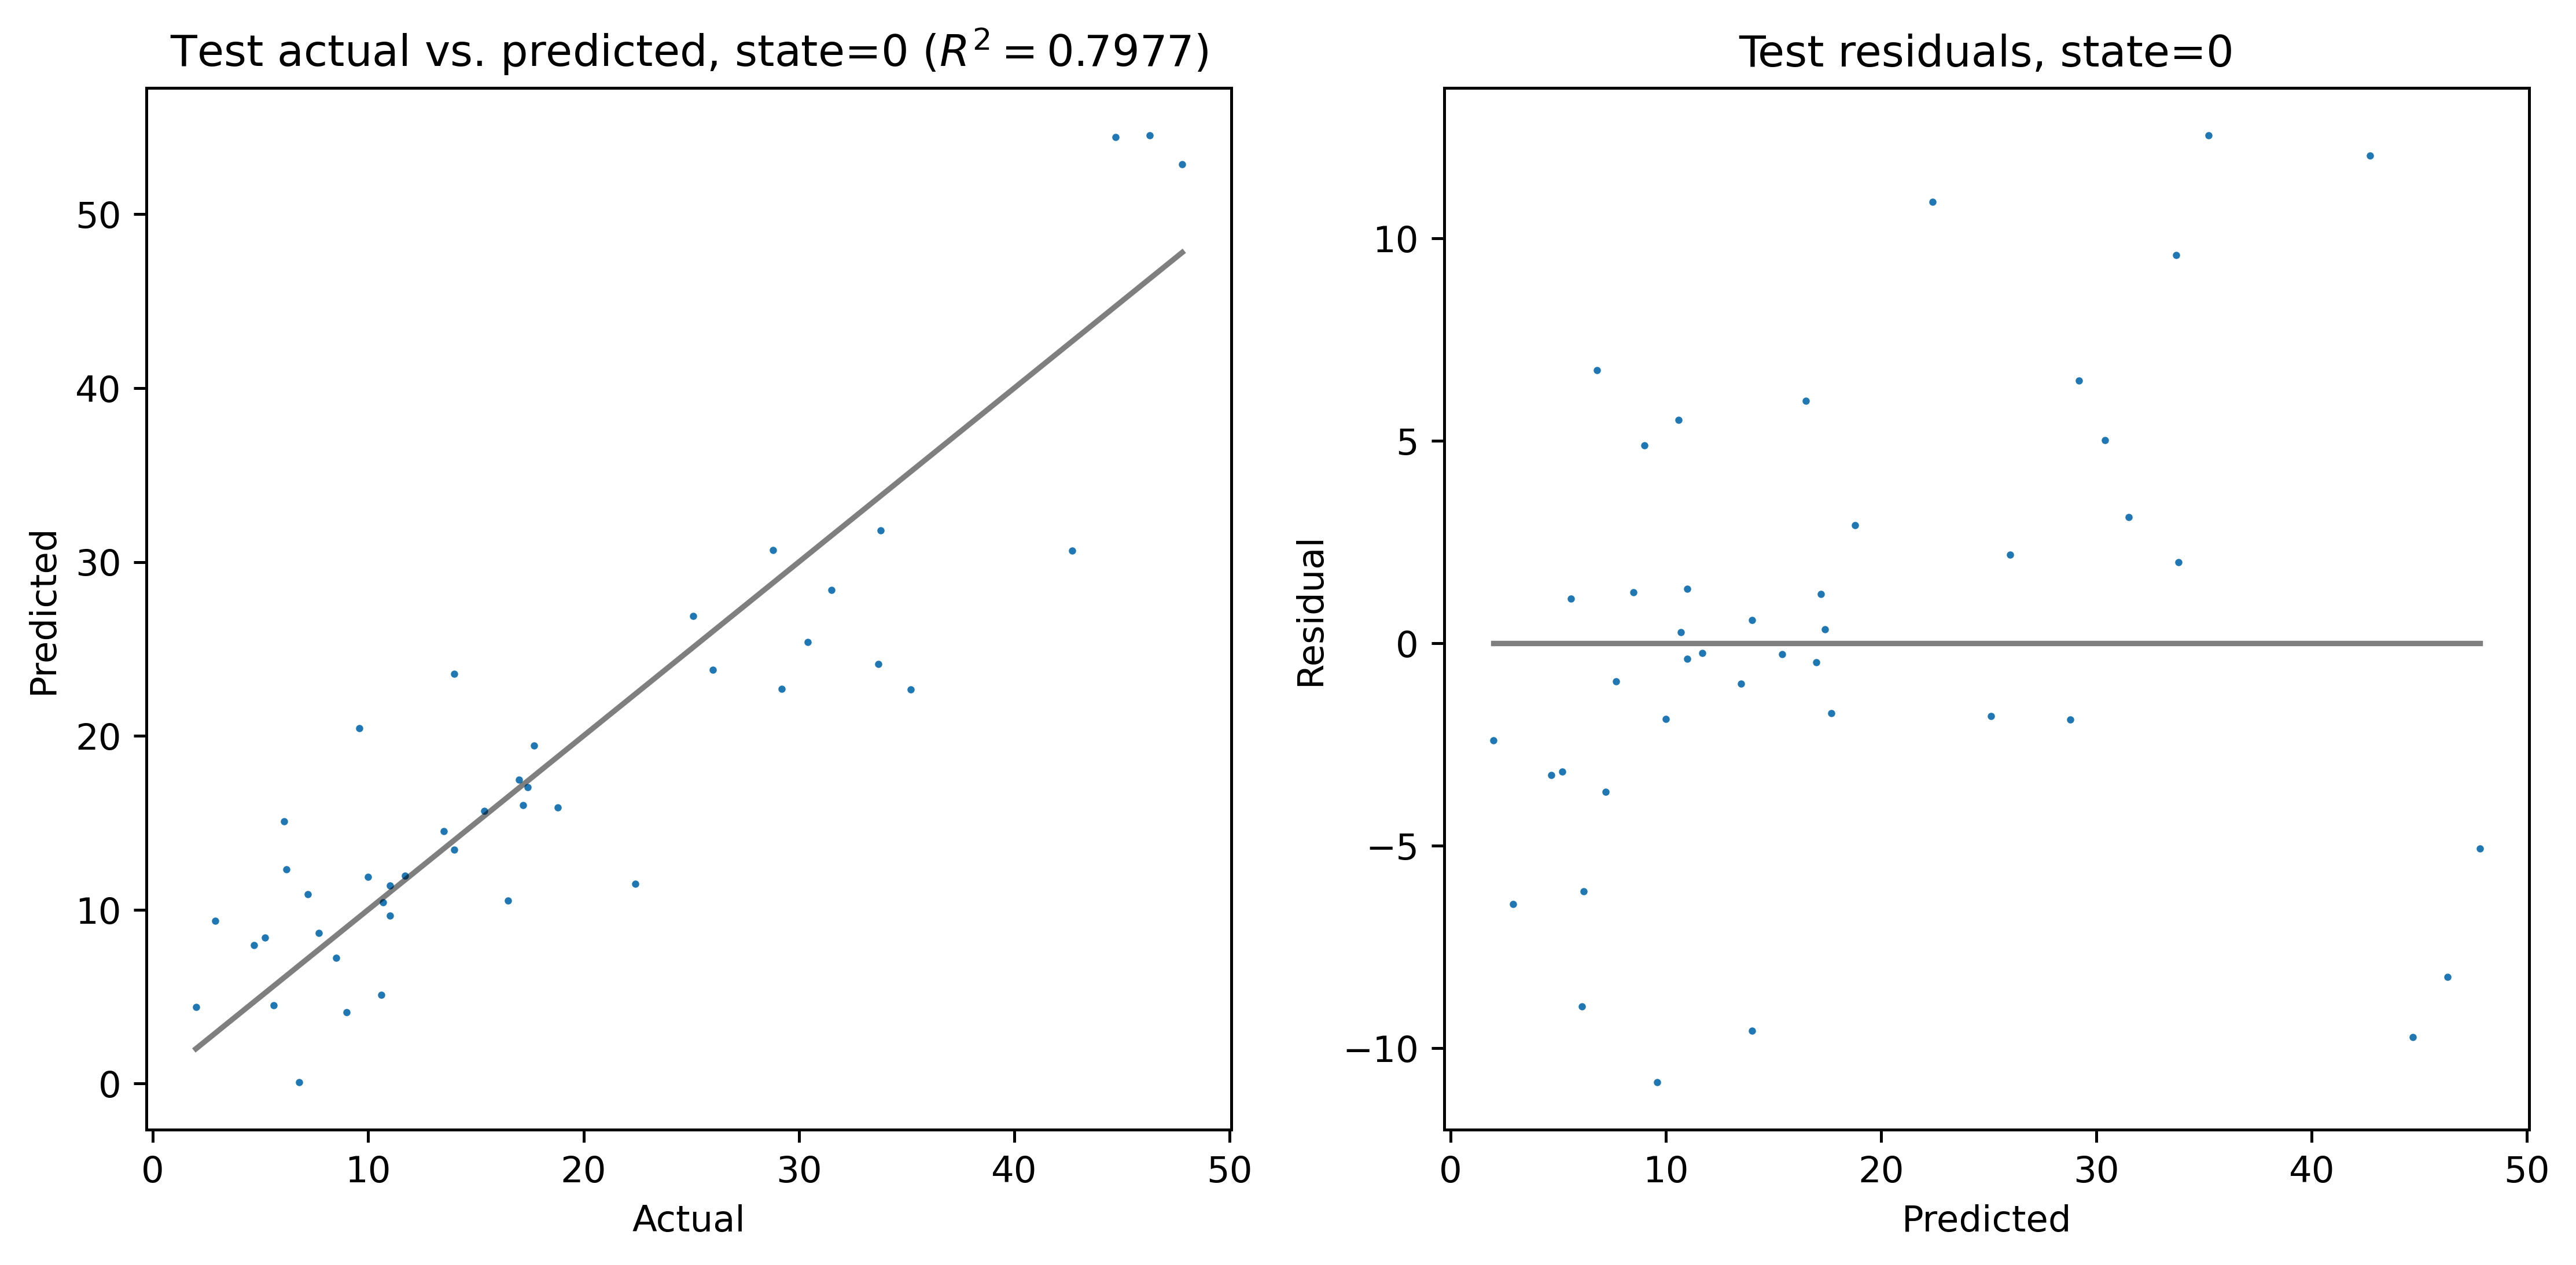

In [13]:
Image(filename="../artifacts/04_noisy_data_005/01_ols/plots/ols_0_test.png")

This looks good! Let's use `random_state = 42` now.

Train:

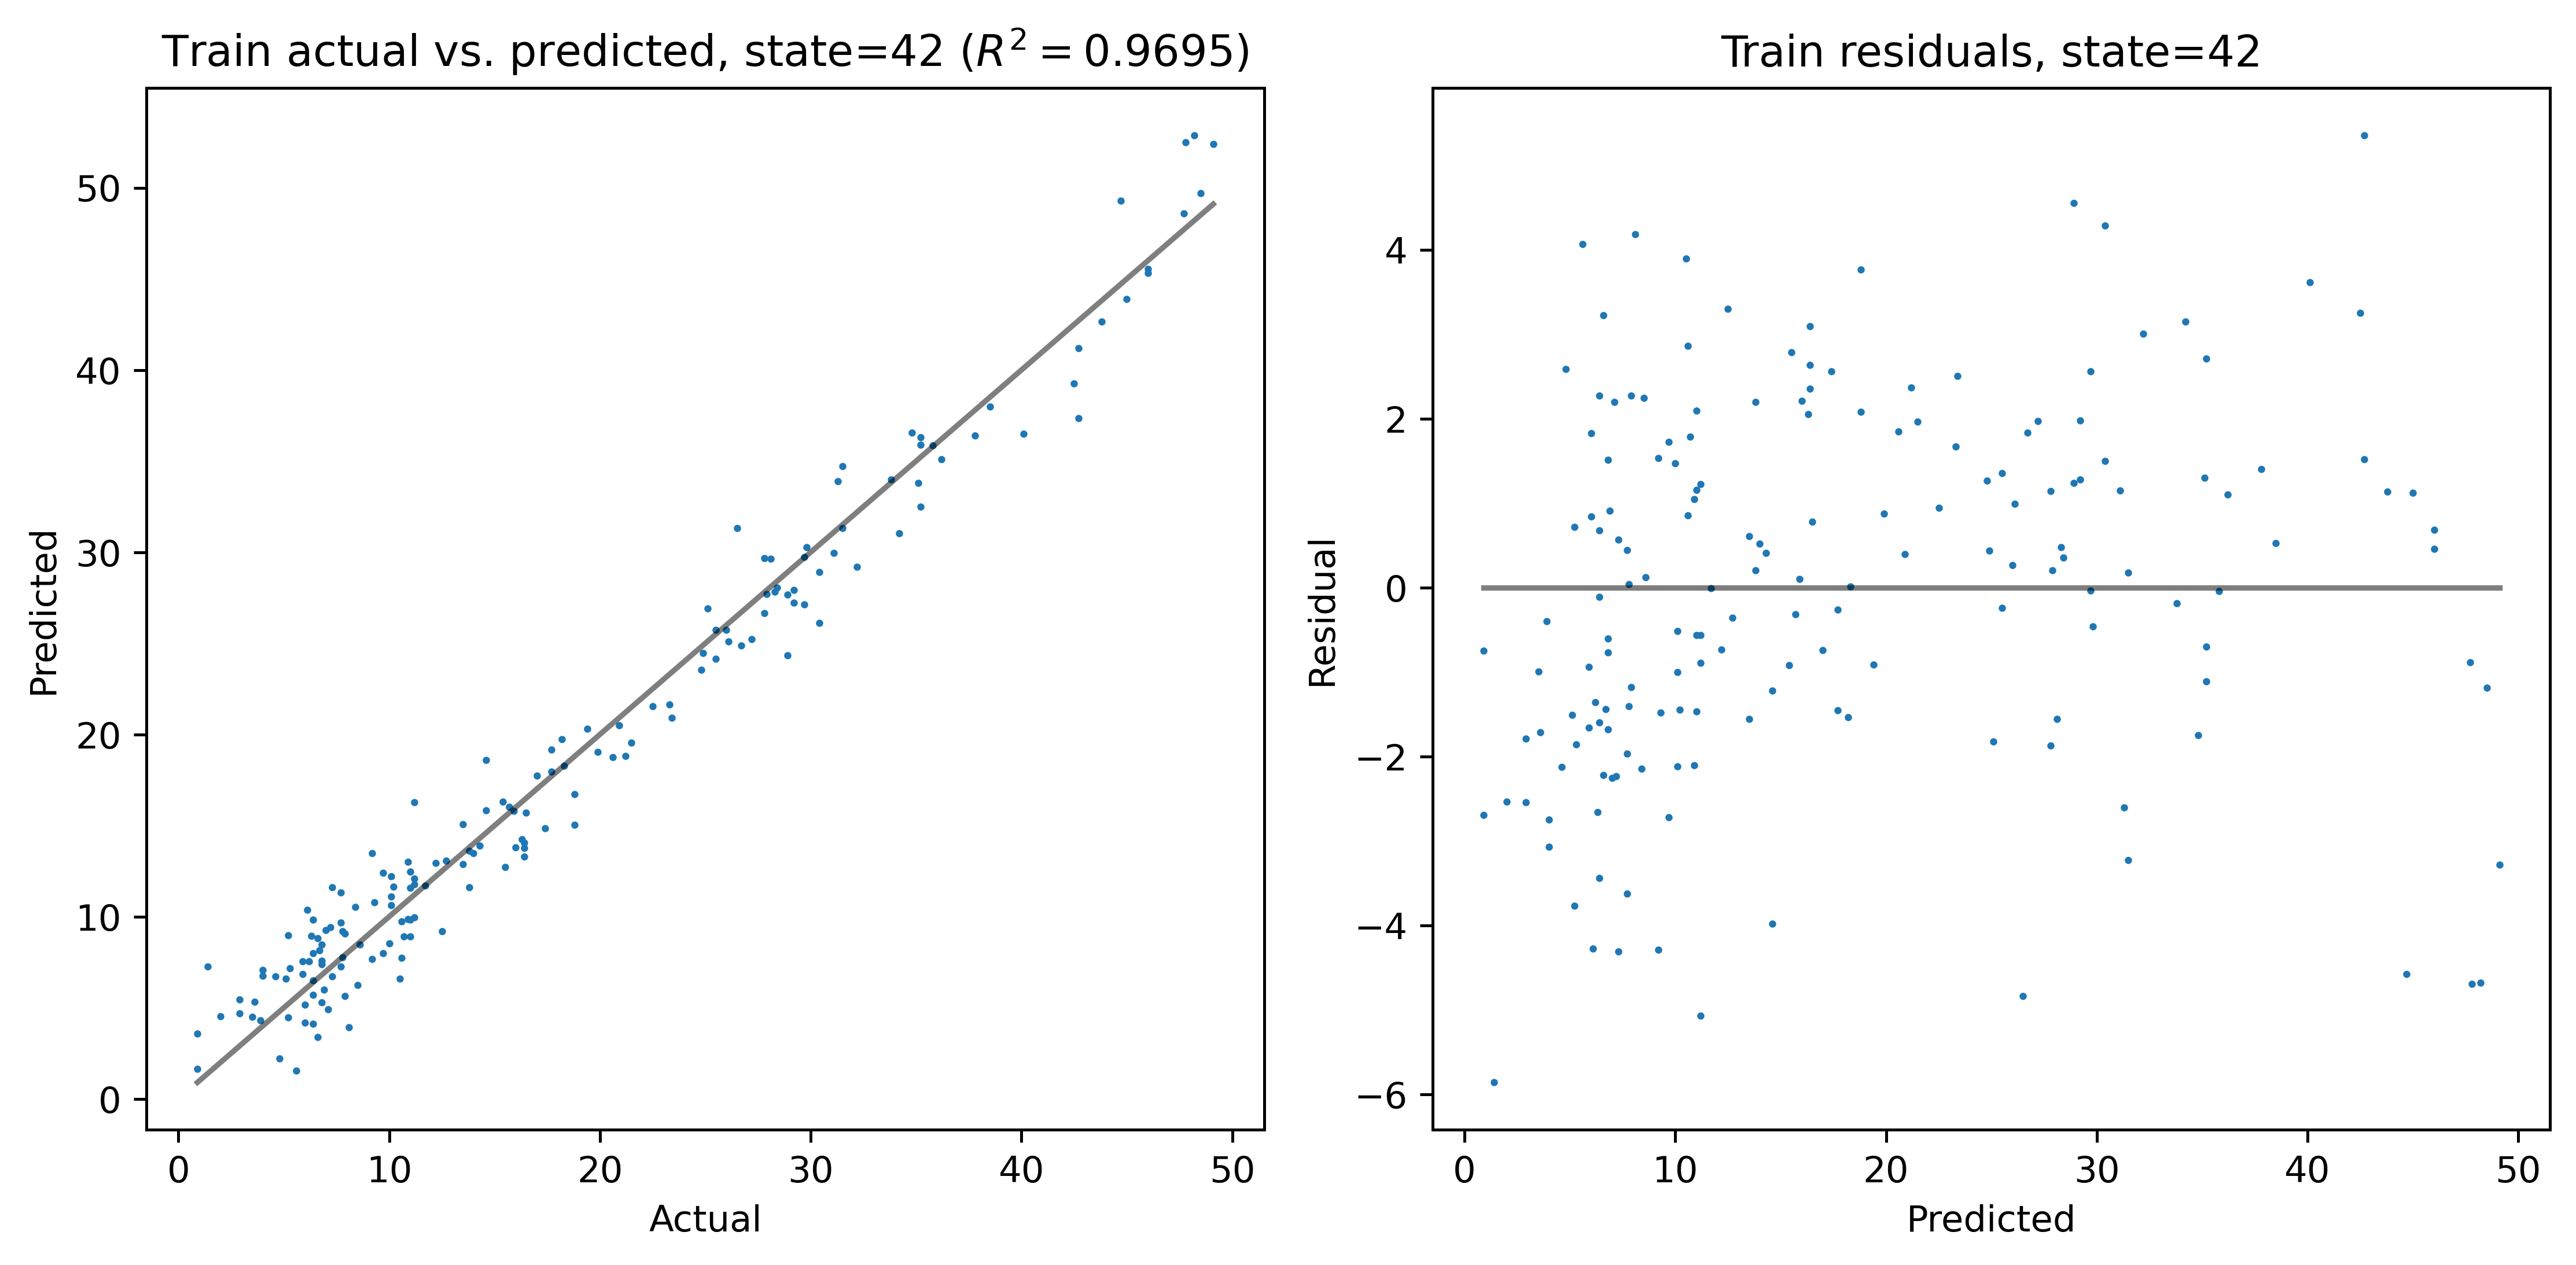

In [14]:
Image(filename="../artifacts/04_noisy_data_005/01_ols/plots/ols_42_train.png")

Test:

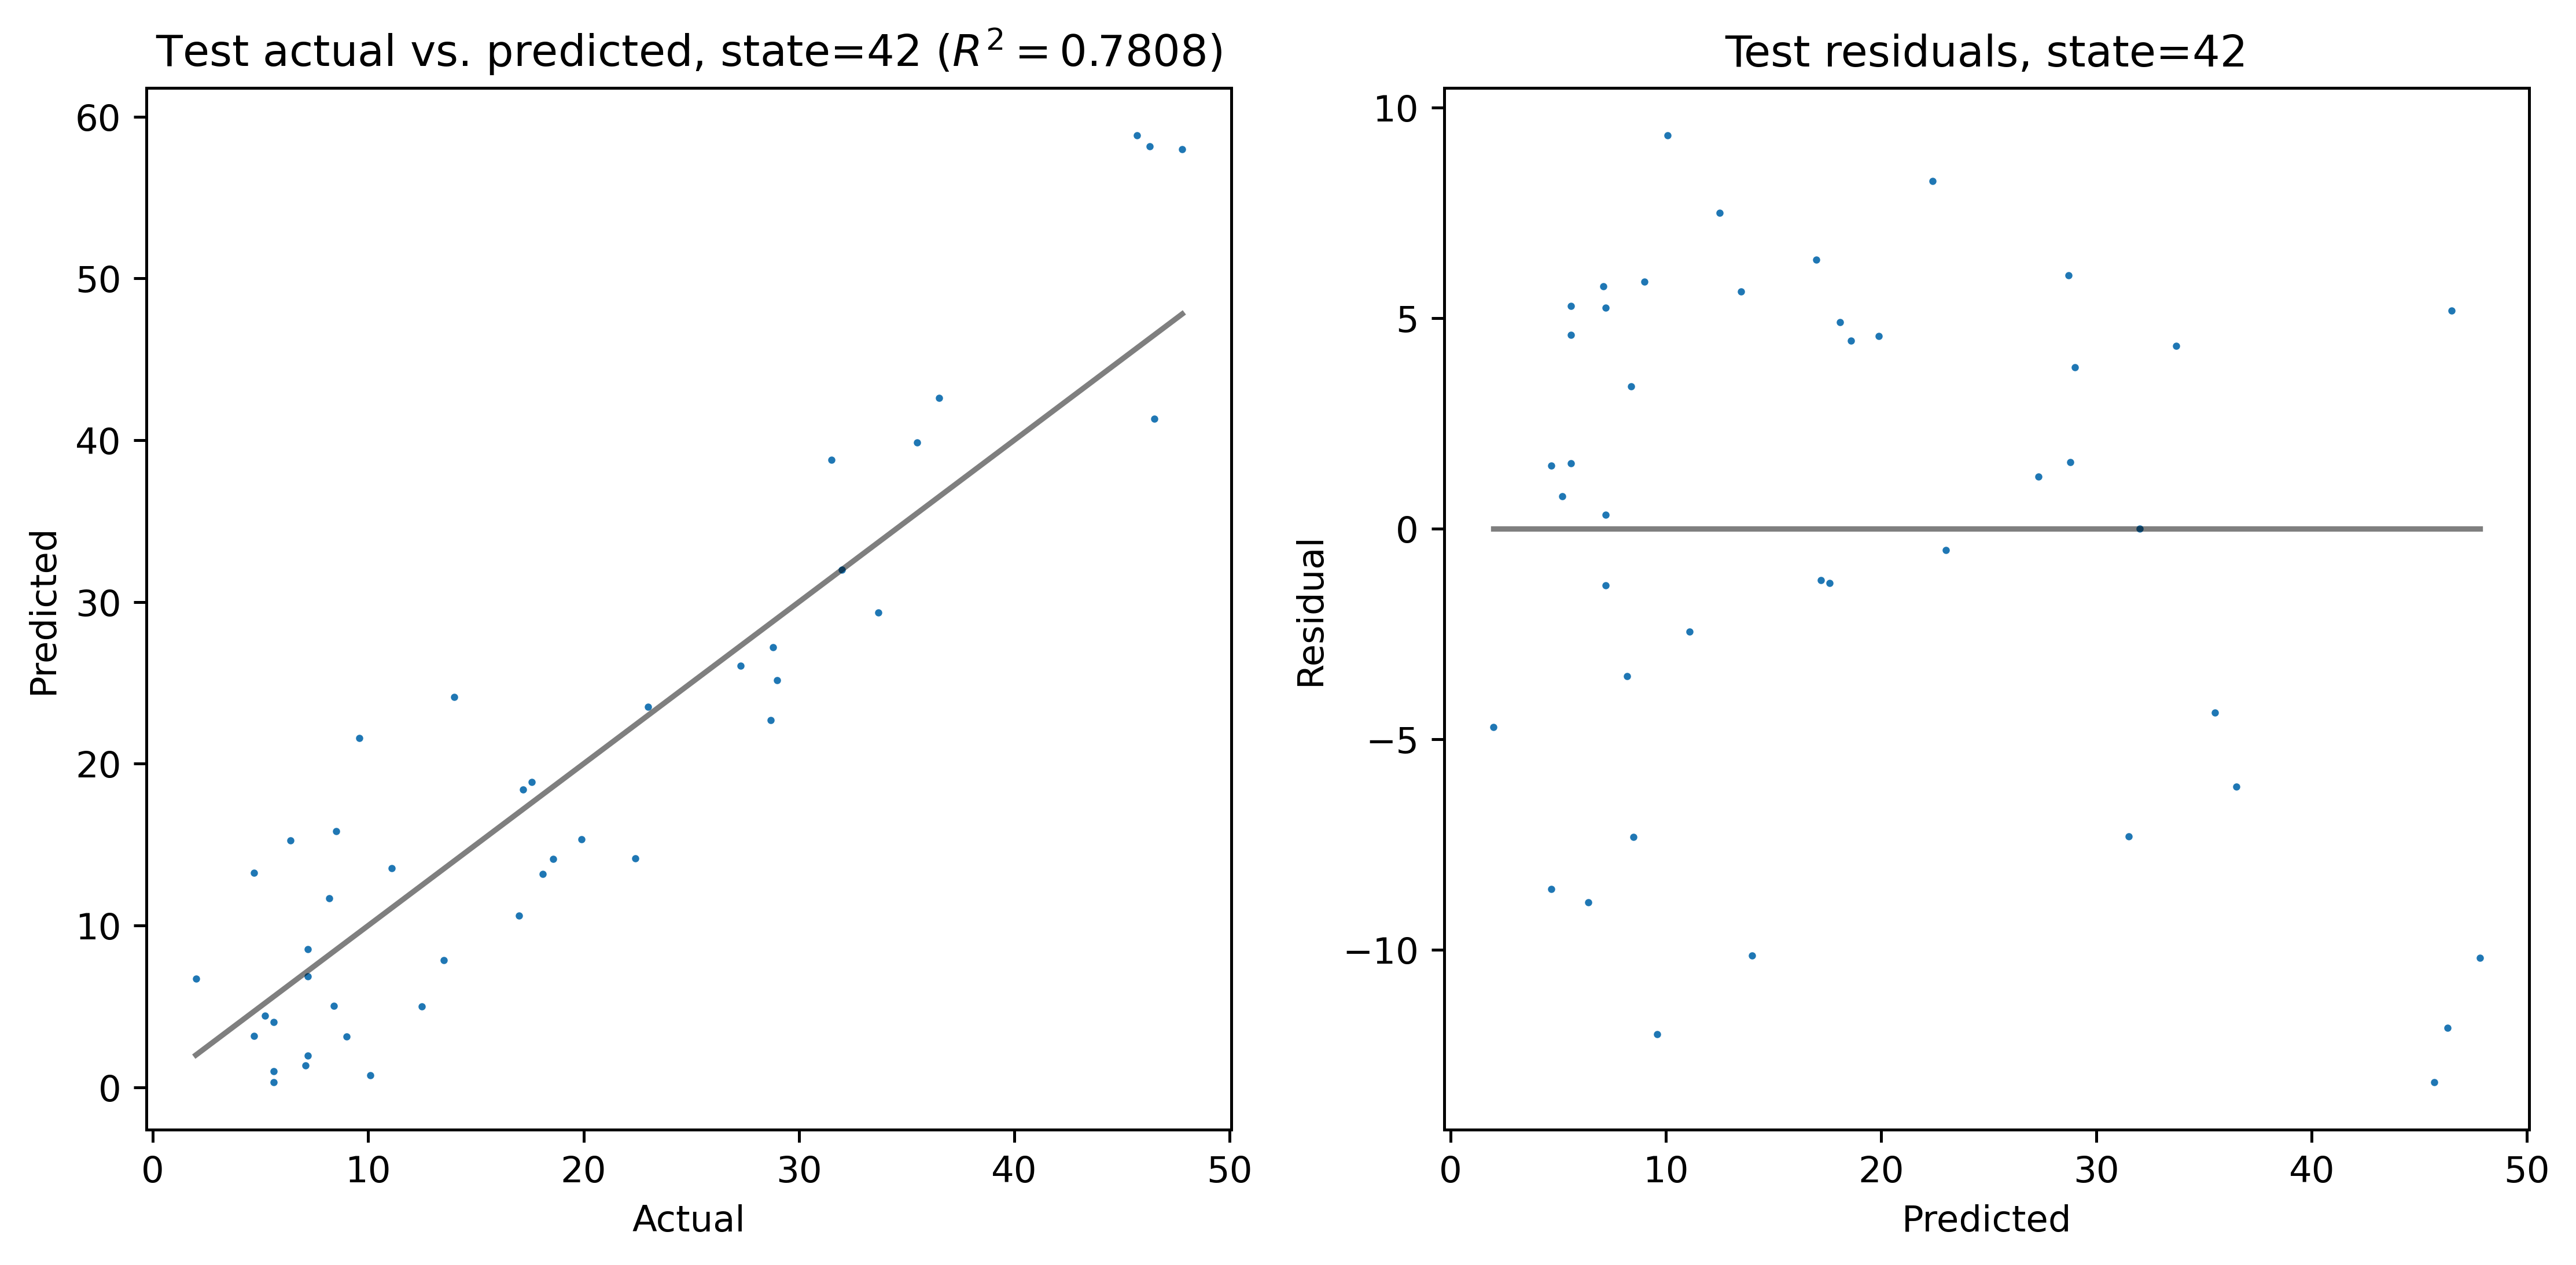

In [15]:
Image(filename="../artifacts/04_noisy_data_005/01_ols/plots/ols_42_test.png")

Test $R^{2}$ is lower for this split, with some strong outliers. Let's look at them all together.

#### $R^{2}$ values

We examine $R^{2}$ values for each of the three fits.

In [16]:
print("R^2 for full data:", round(all_results["ols_full"].r2_score, 4))
print()
print("Train R^2 for random state 0:", round(all_results["ols_0_train"].r2_score, 4))
print("Test R^2 for random state 0: ", round(all_results["ols_0_test"].r2_score, 4))
print()
print("Train R^2 for random state 42:", round(all_results["ols_42_train"].r2_score, 4))
print("Test R^2 for random state 42: ", round(all_results["ols_42_test"].r2_score, 4))

R^2 for full data: 0.956

Train R^2 for random state 0: 0.9691
Test R^2 for random state 0:  0.7977

Train R^2 for random state 42: 0.9695
Test R^2 for random state 42:  0.7808


Interesting! We see that two random states have drastically different test $R^{2}$ values. Because of this, we choose to move to cross-validation to truly diagnose linear regression's capabilities for these data.

Popular choices for cross-validation are 5-fold and 10-fold; we choose 10-fold here because computations aren't expensive for this project and 10 gives us less bias in our error estimates. We also use repeated 10-fold cross-validation to get a better sense for the fits.

## FLR

### Analyze results

Throughout this section, we vary values for $K_{X}$, $K_{\beta}$, and $\lambda$, which are the number of basis functions for the functional inputs, number of basis functions for the coefficient function, and roughness penalty in the least squares problem. We always examine predictive $R^{2}$ in leave-one-out cross-validation.

#### $(K_{X}, K_{\beta}, \lambda)$-sweep

Let's do a huge sweep over these three parameters to see what happens. We use:
- $K_{X} \in \{5, 10, 15, \dots, 45\}$
- $K_{\beta} \in \{5, 10, 15, \dots, 45\}$
- $\log_{10}(\lambda) \in \{-15, -14, \dots, 4\}$

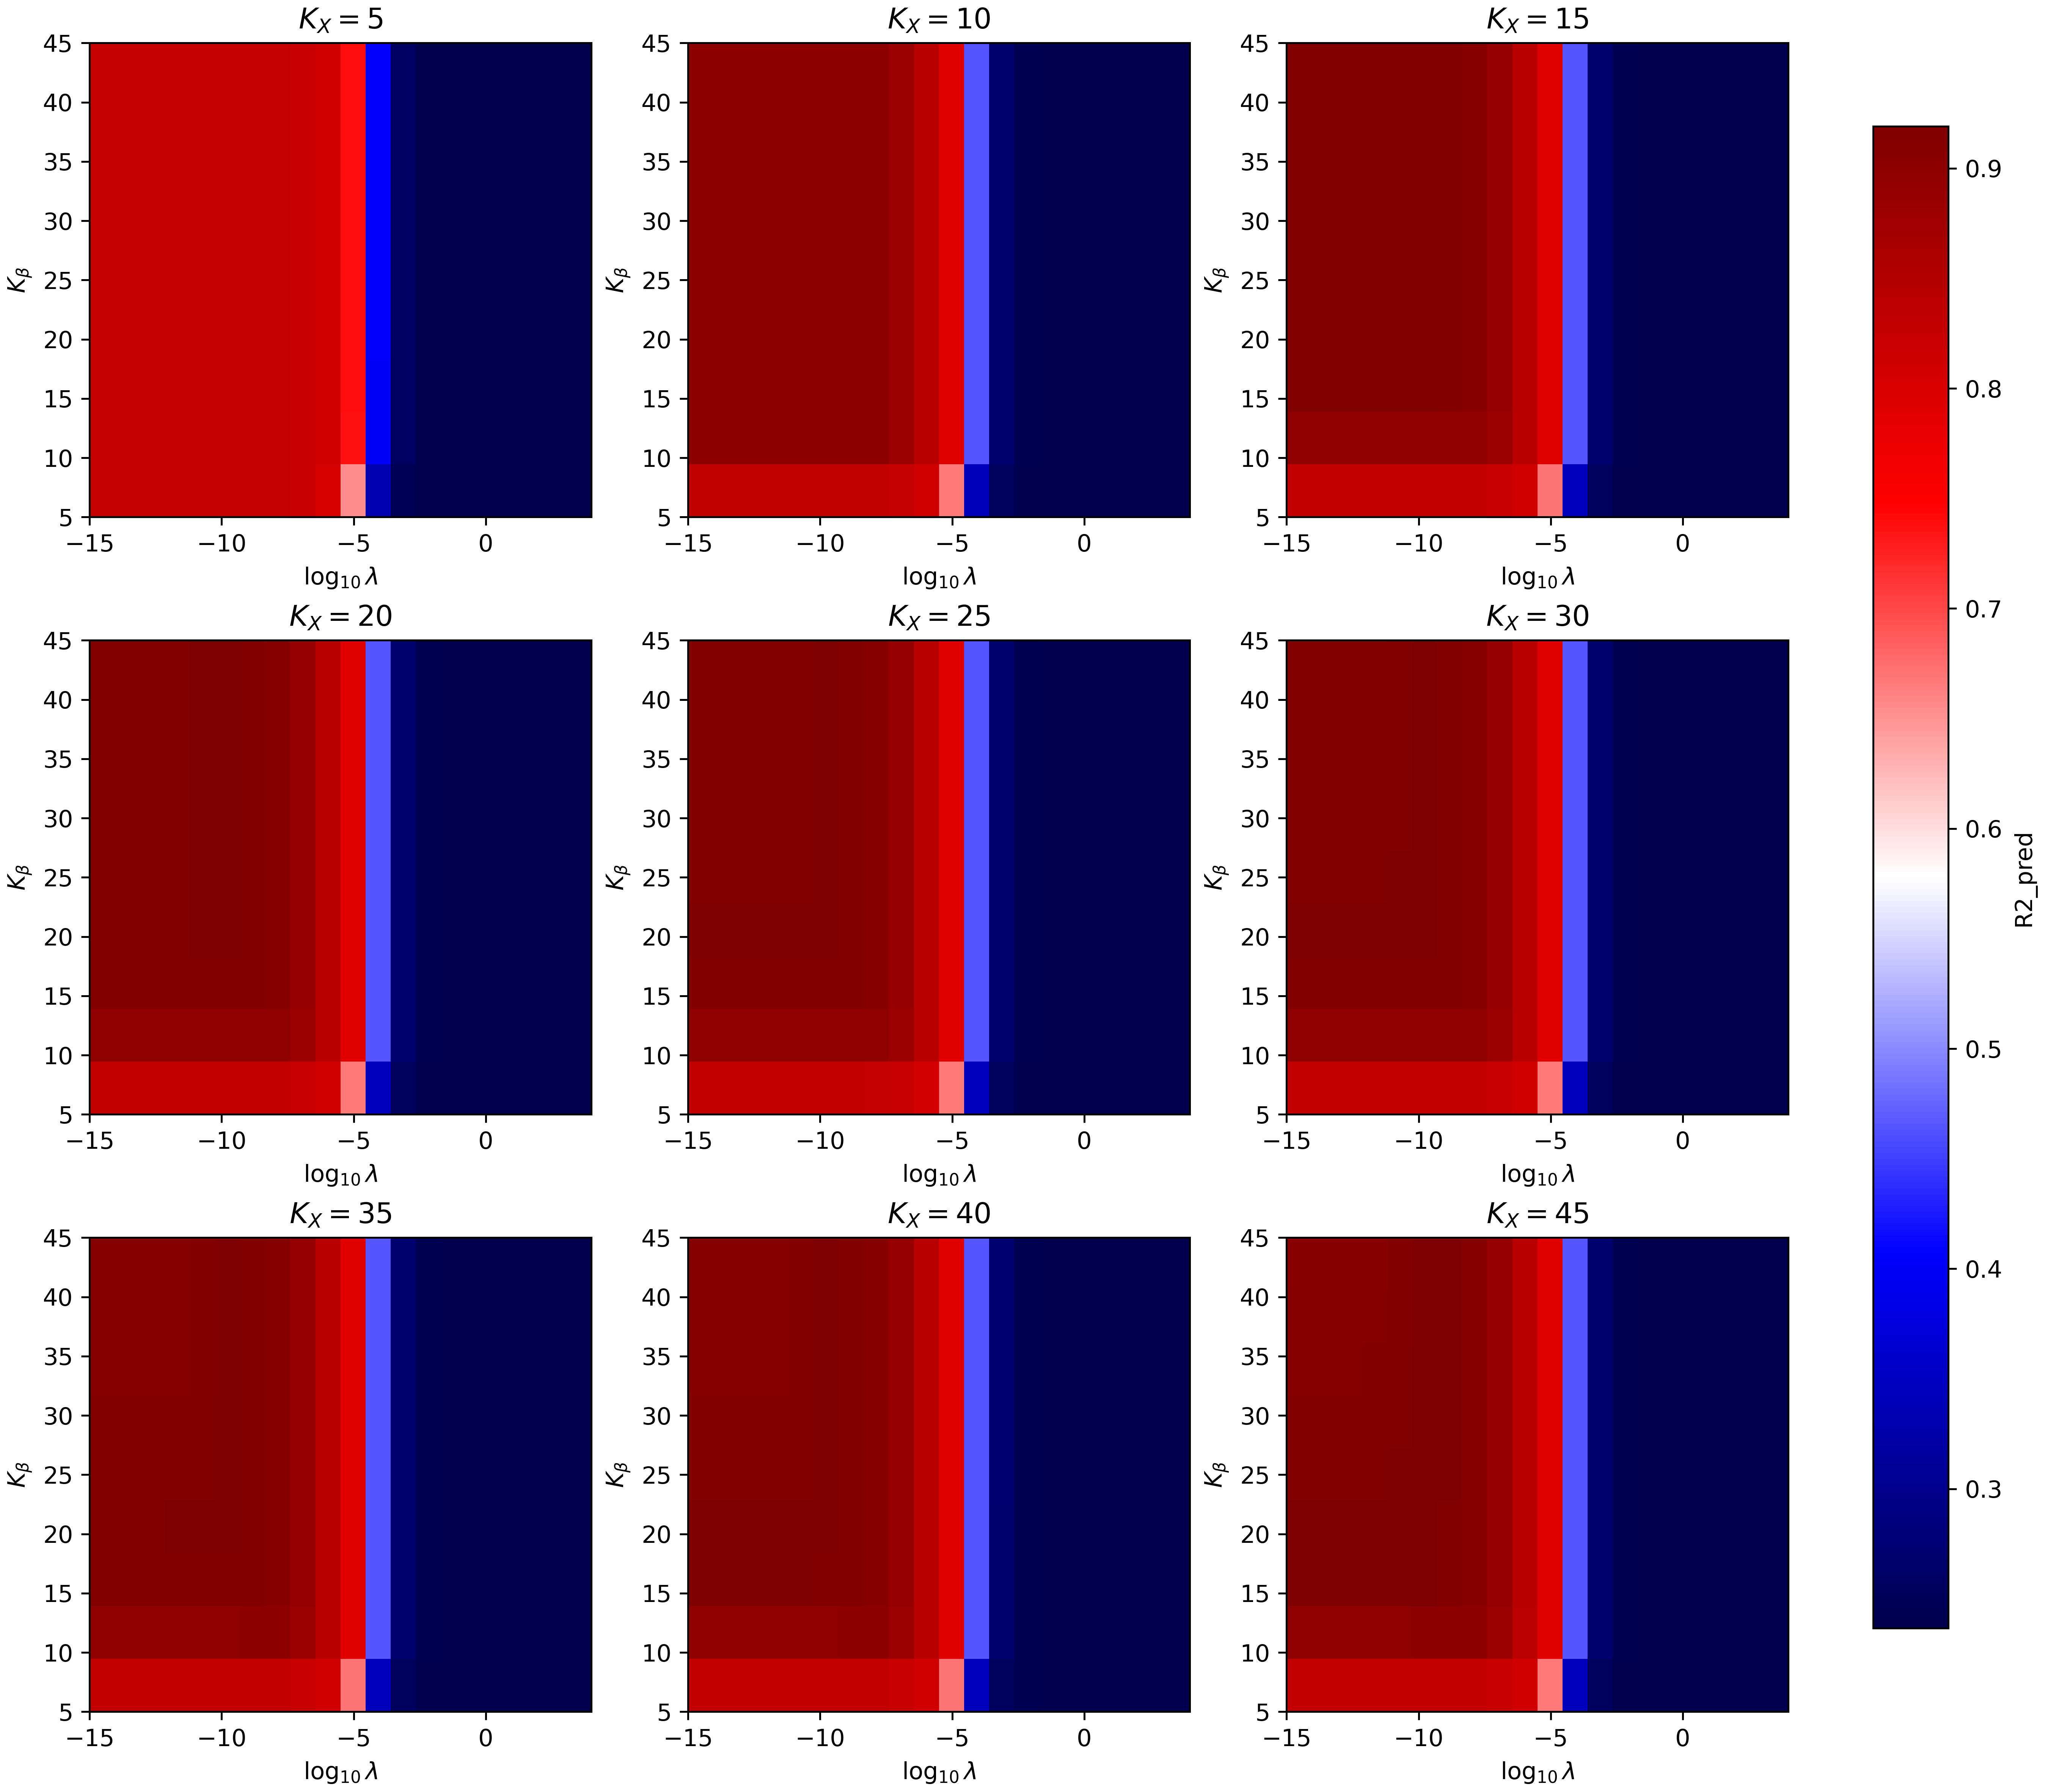

In [17]:
Image(filename="../artifacts/04_noisy_data_005/03_flr/plots/R2_heatmaps.png", width=800)

Predictive $R^{2}$ doesn't seem to change much across different values of $K_{X}$ (i.e. different plots) once $K_{X} \geq 10$!

#### For fixed $K_{X}$, examine how $\lambda$ affects $R_{pred}^{2}$ per $K_{\beta}$

We present the above data in a different form. Again, each plot is a different value for $K_{X}$. However, now we plot a curve for each $K_{\beta}$ value, where the independent variable is $\lambda$.

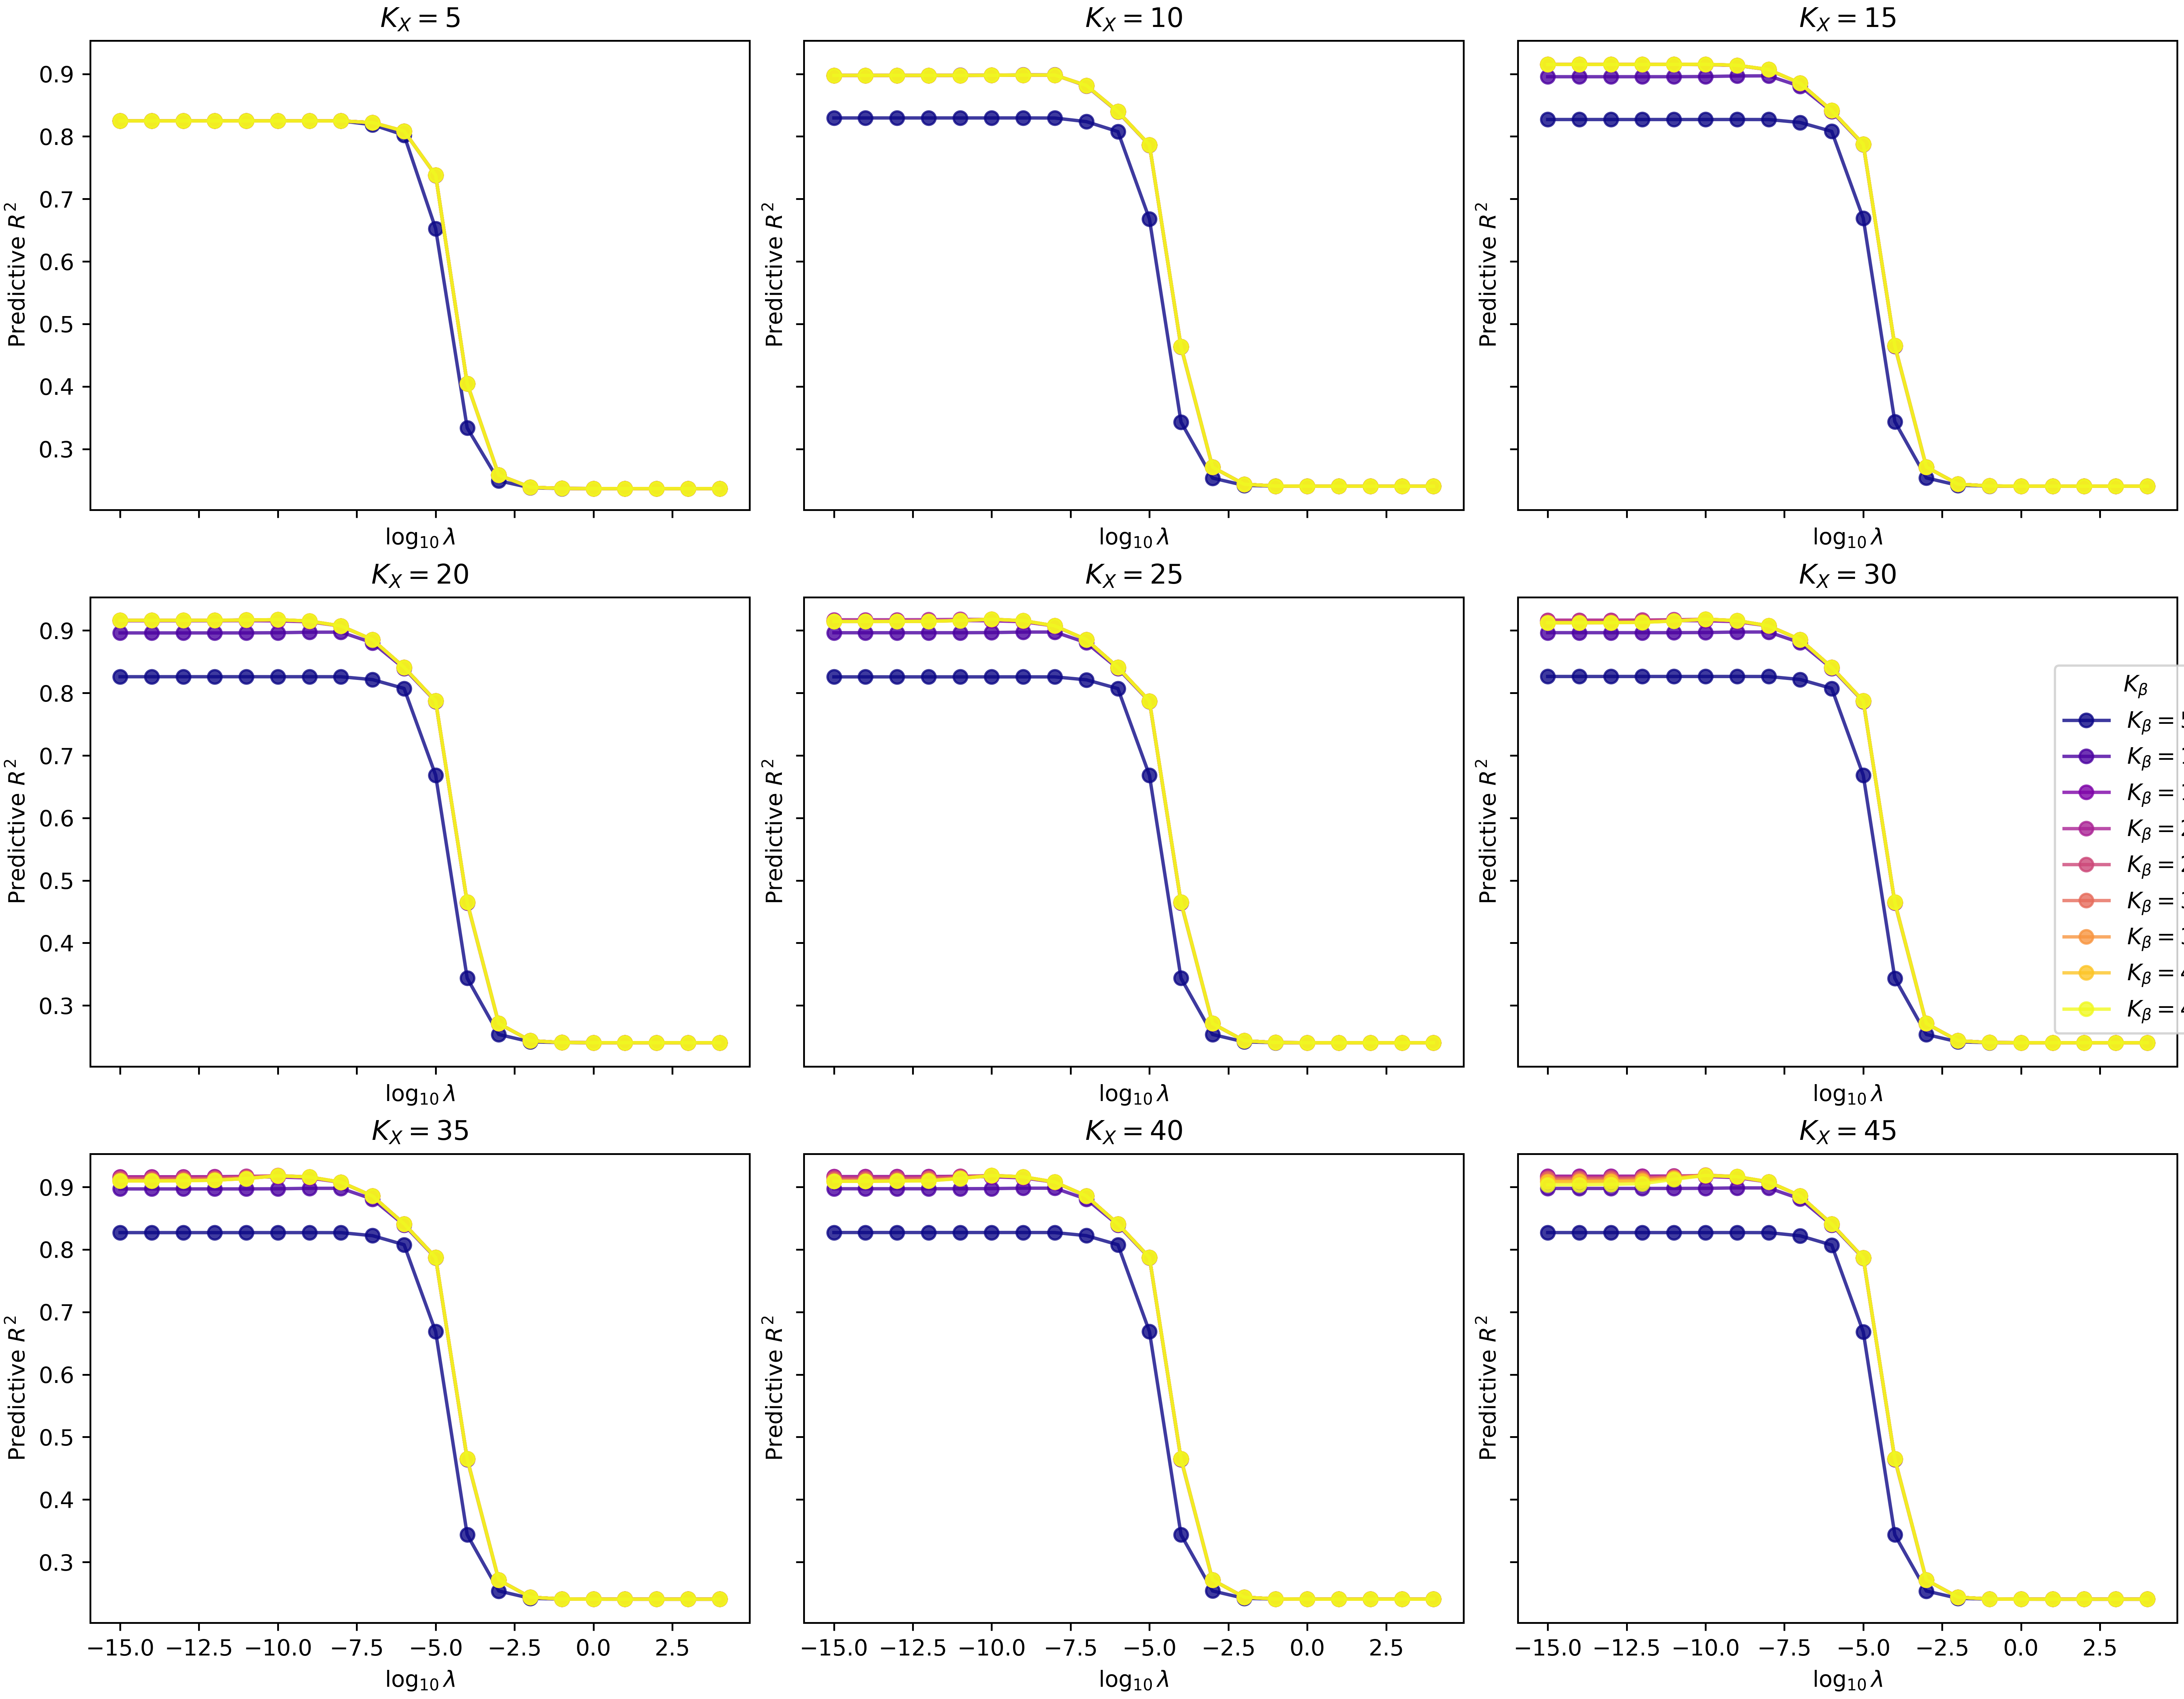

In [18]:
Image(filename="../artifacts/04_noisy_data_005/03_flr/plots/R2_vs_lambda_per_K.png", width=800)

This plot shows that, as long as $K_{\beta} \geq 5$ (i.e. we're not looking at the most blue curve), for a given $K_{X}$ (plot) the only parameter that matters is $\lambda$ (the independent variable). In every case, there is a sharp decrease in predictive $R^{2}$ once $\lambda$ grows past about $10^{-8}$.

#### For each $(K_{X}, K_{\beta})$-pair, if we optimize $\lambda$ correctly, what is the maximum $R_{pred}^{2}$?

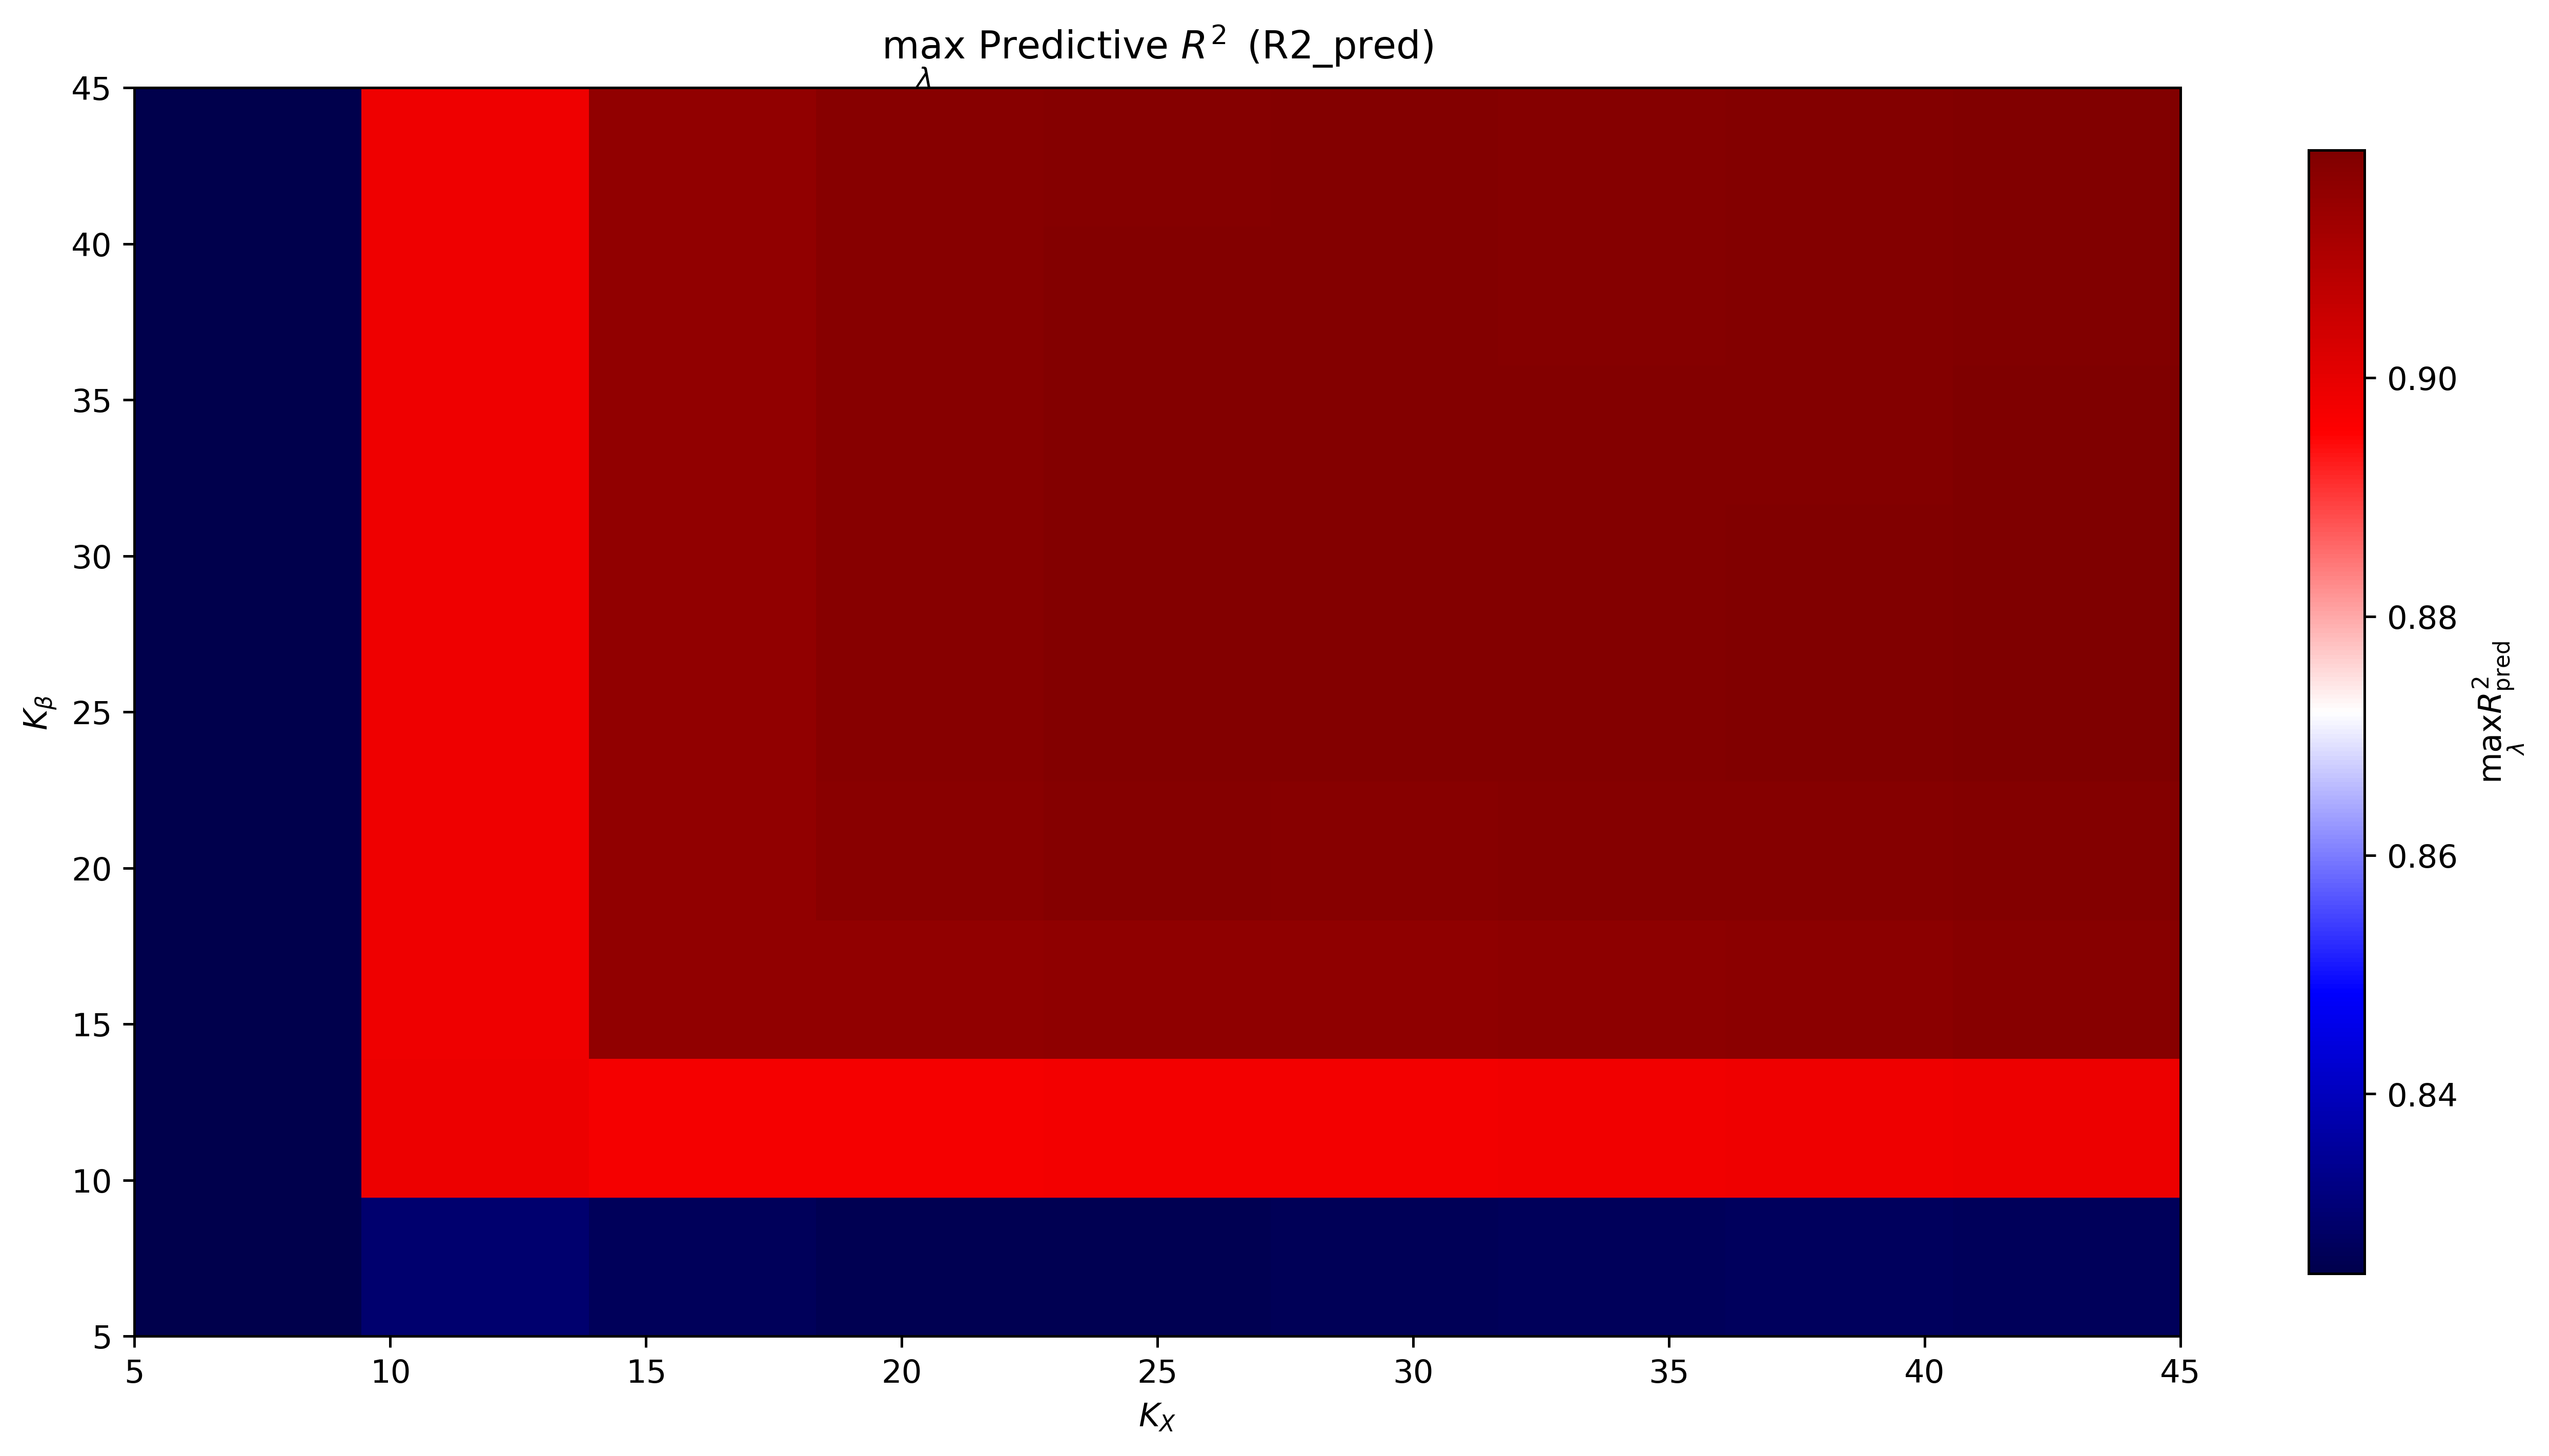

In [19]:
Image(filename="../artifacts/04_noisy_data_005/03_flr/plots/best_R2.png", width=800)

This plot shows that, given we choose $\lambda$ correctly, our best choices for $K_{X}$ and $K_{\beta}$ appear to be at least 30, with 30 basis functions for the functional inputs leading to great accuracy. Which hyperparameters produce the best predictive $R^{2}$ overall?

In [20]:
overall_predictive_df = pd.read_csv("../artifacts/04_noisy_data_005/03_flr/analysis_results/hyperparameter_sweep.csv")

overall_predictive_df.loc[overall_predictive_df["R2_pred"] == overall_predictive_df["R2_pred"].max()]

K_X  K_beta           lam  log10_lam  R2_pred     CV_score         df  \
1545   45      30  1.000000e-10      -10.0  0.91905  2811.846288  20.982535   

            R2  time_sec  
1545  0.935442  0.000331

We can see that the best results are when:
- $K_{X} = 30$.
- $K_{\beta} = 30$.
- $\lambda = 10^{-15}$.

In this case, predictive $R^{2}$ is 0.965, while $R^{2}$ on the whole data set is given by 0.979. Now, there are many hyperparameter choices that give close to this value.

#### Predictive $R^{2}$ vs. degrees of freedom

As our final plots, we show a relationship that ChatGPT is incredibly interested in. Instead of worrying about three parameters, we only focus on the degrees of freedom of the model. This can be found using the trace of the hat matrix, and lower means less flexbility in the model. In this case, it means a smoother fit, as $\lambda$ increasing implies hat matrix eigenvalues decreasing.

First, we plot all the values of $R_{pred}^{2}$ vs. $df$, colored by $K_{beta}$.

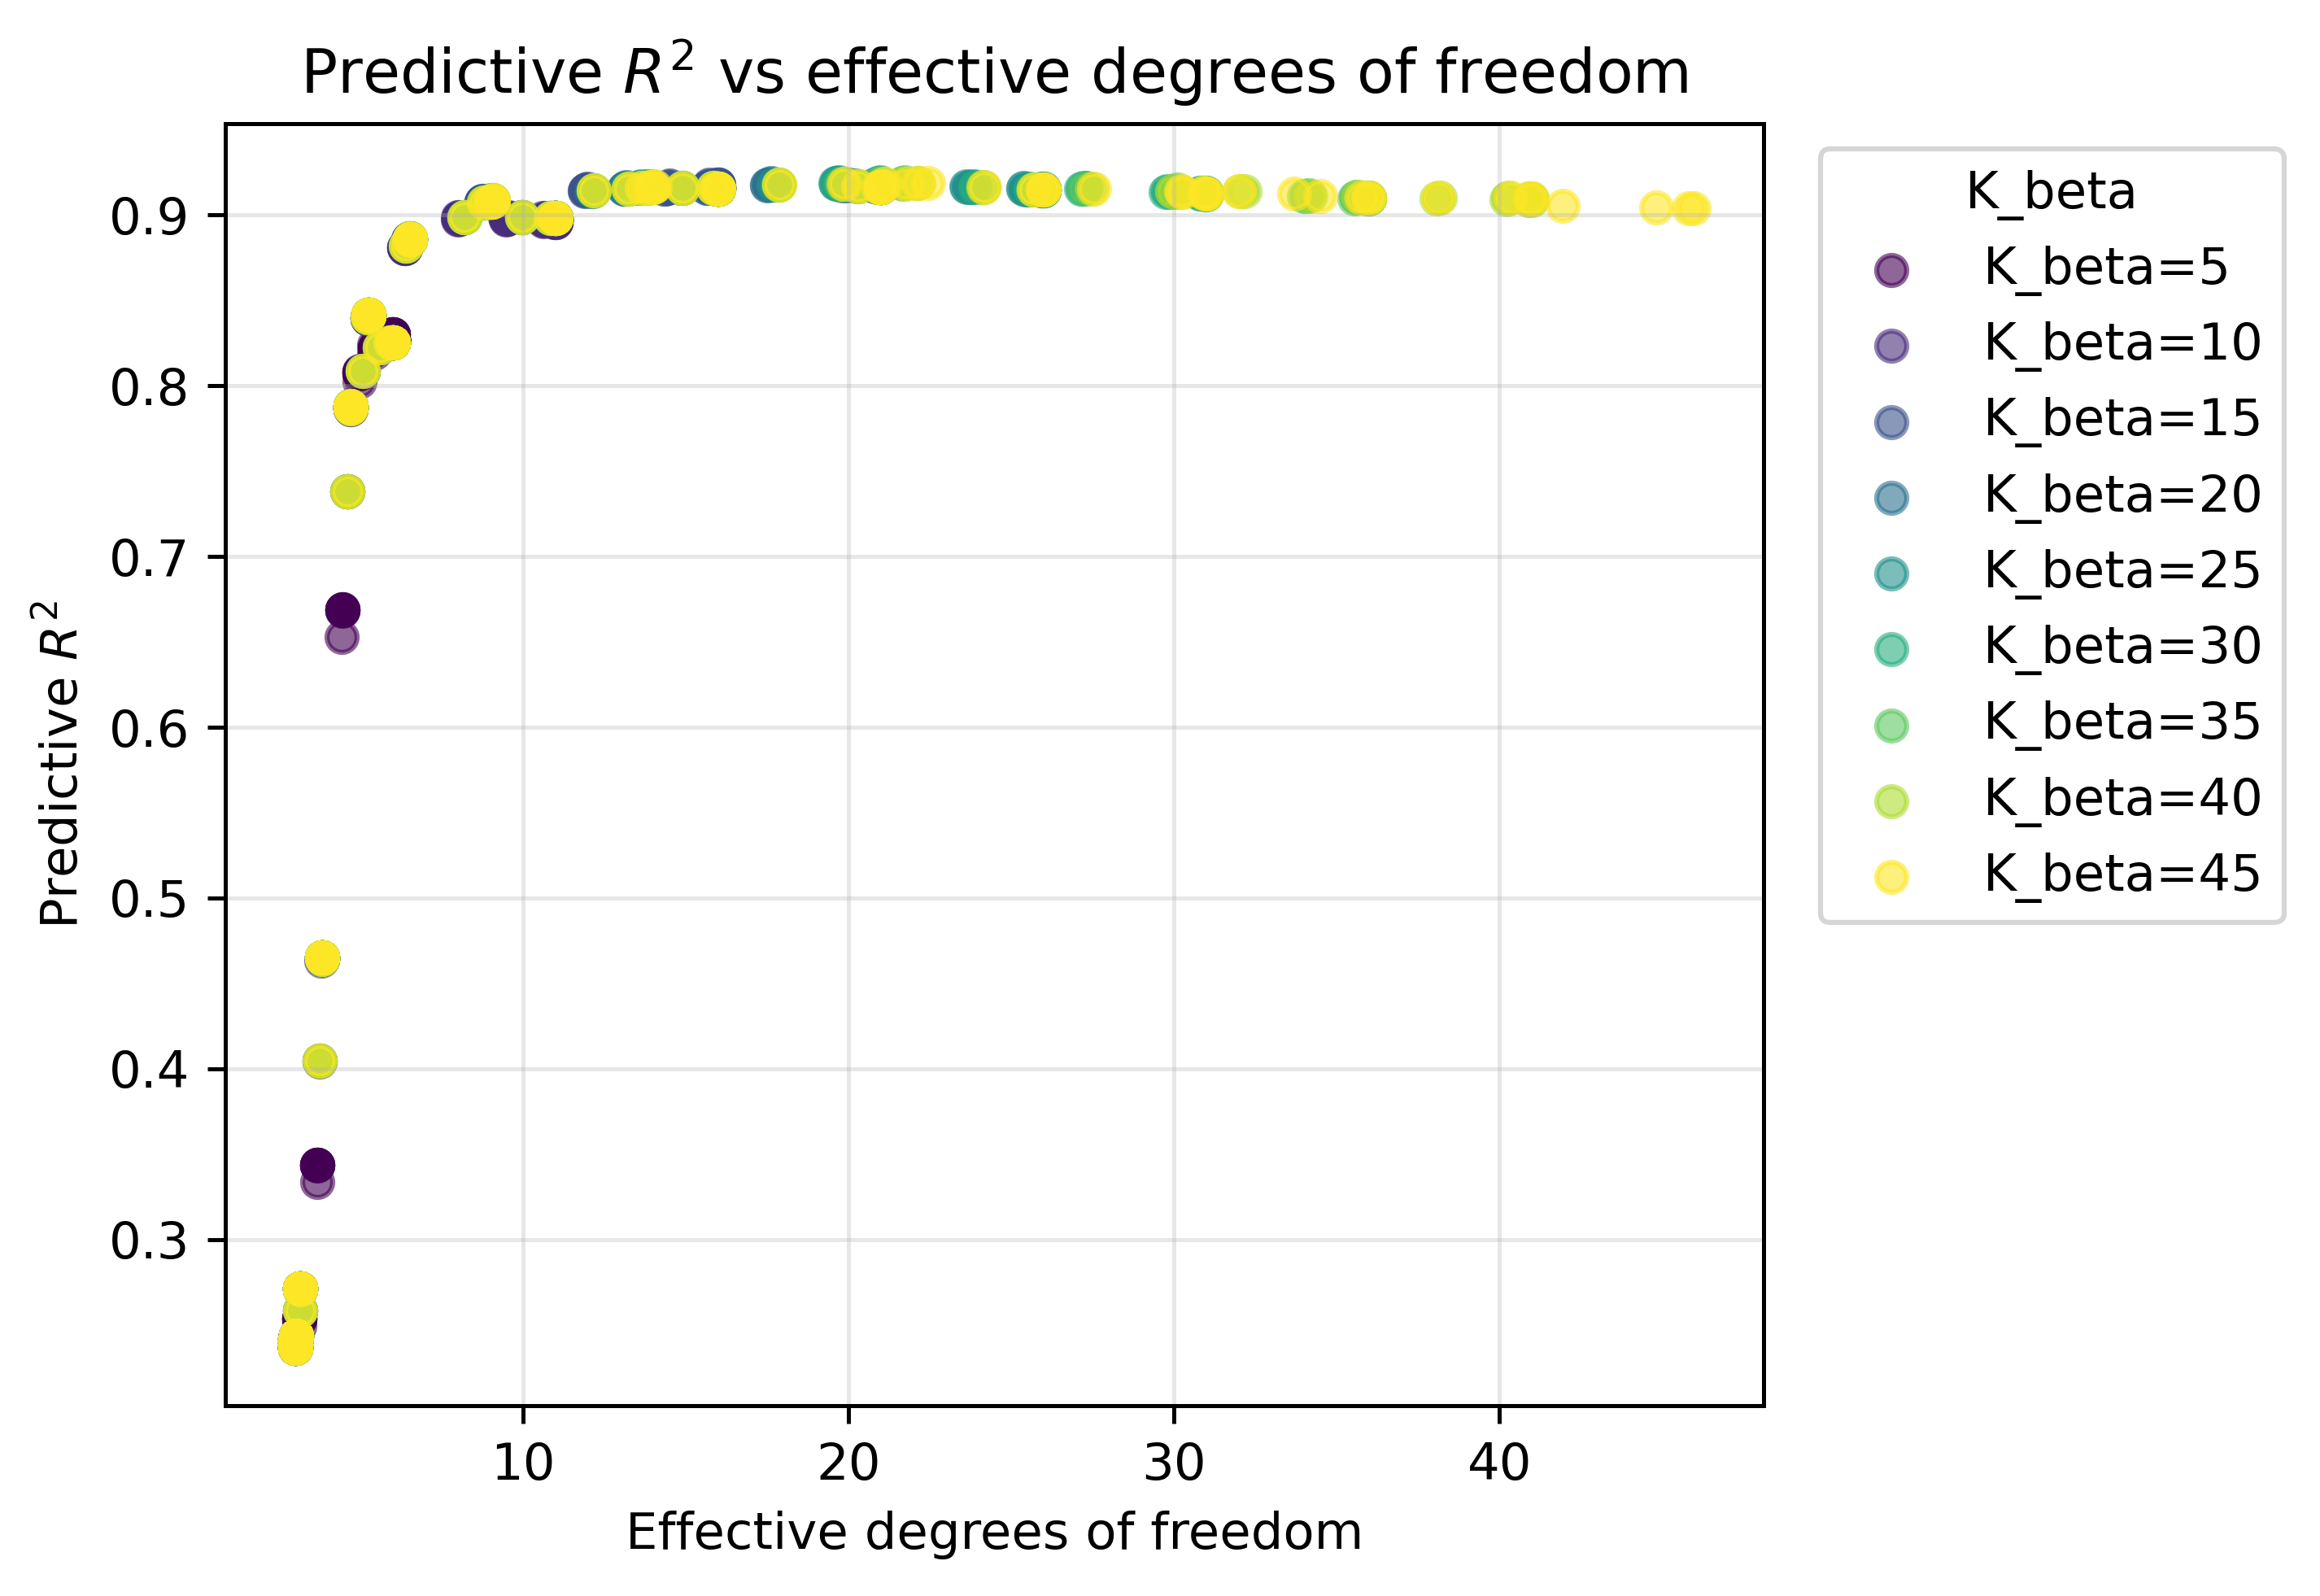

In [21]:
Image(filename="../artifacts/04_noisy_data_005/03_flr/plots/R2_vs_df.png", width=600)

Now, we form 15 bins according to $df$ and plot means and standard deviations.

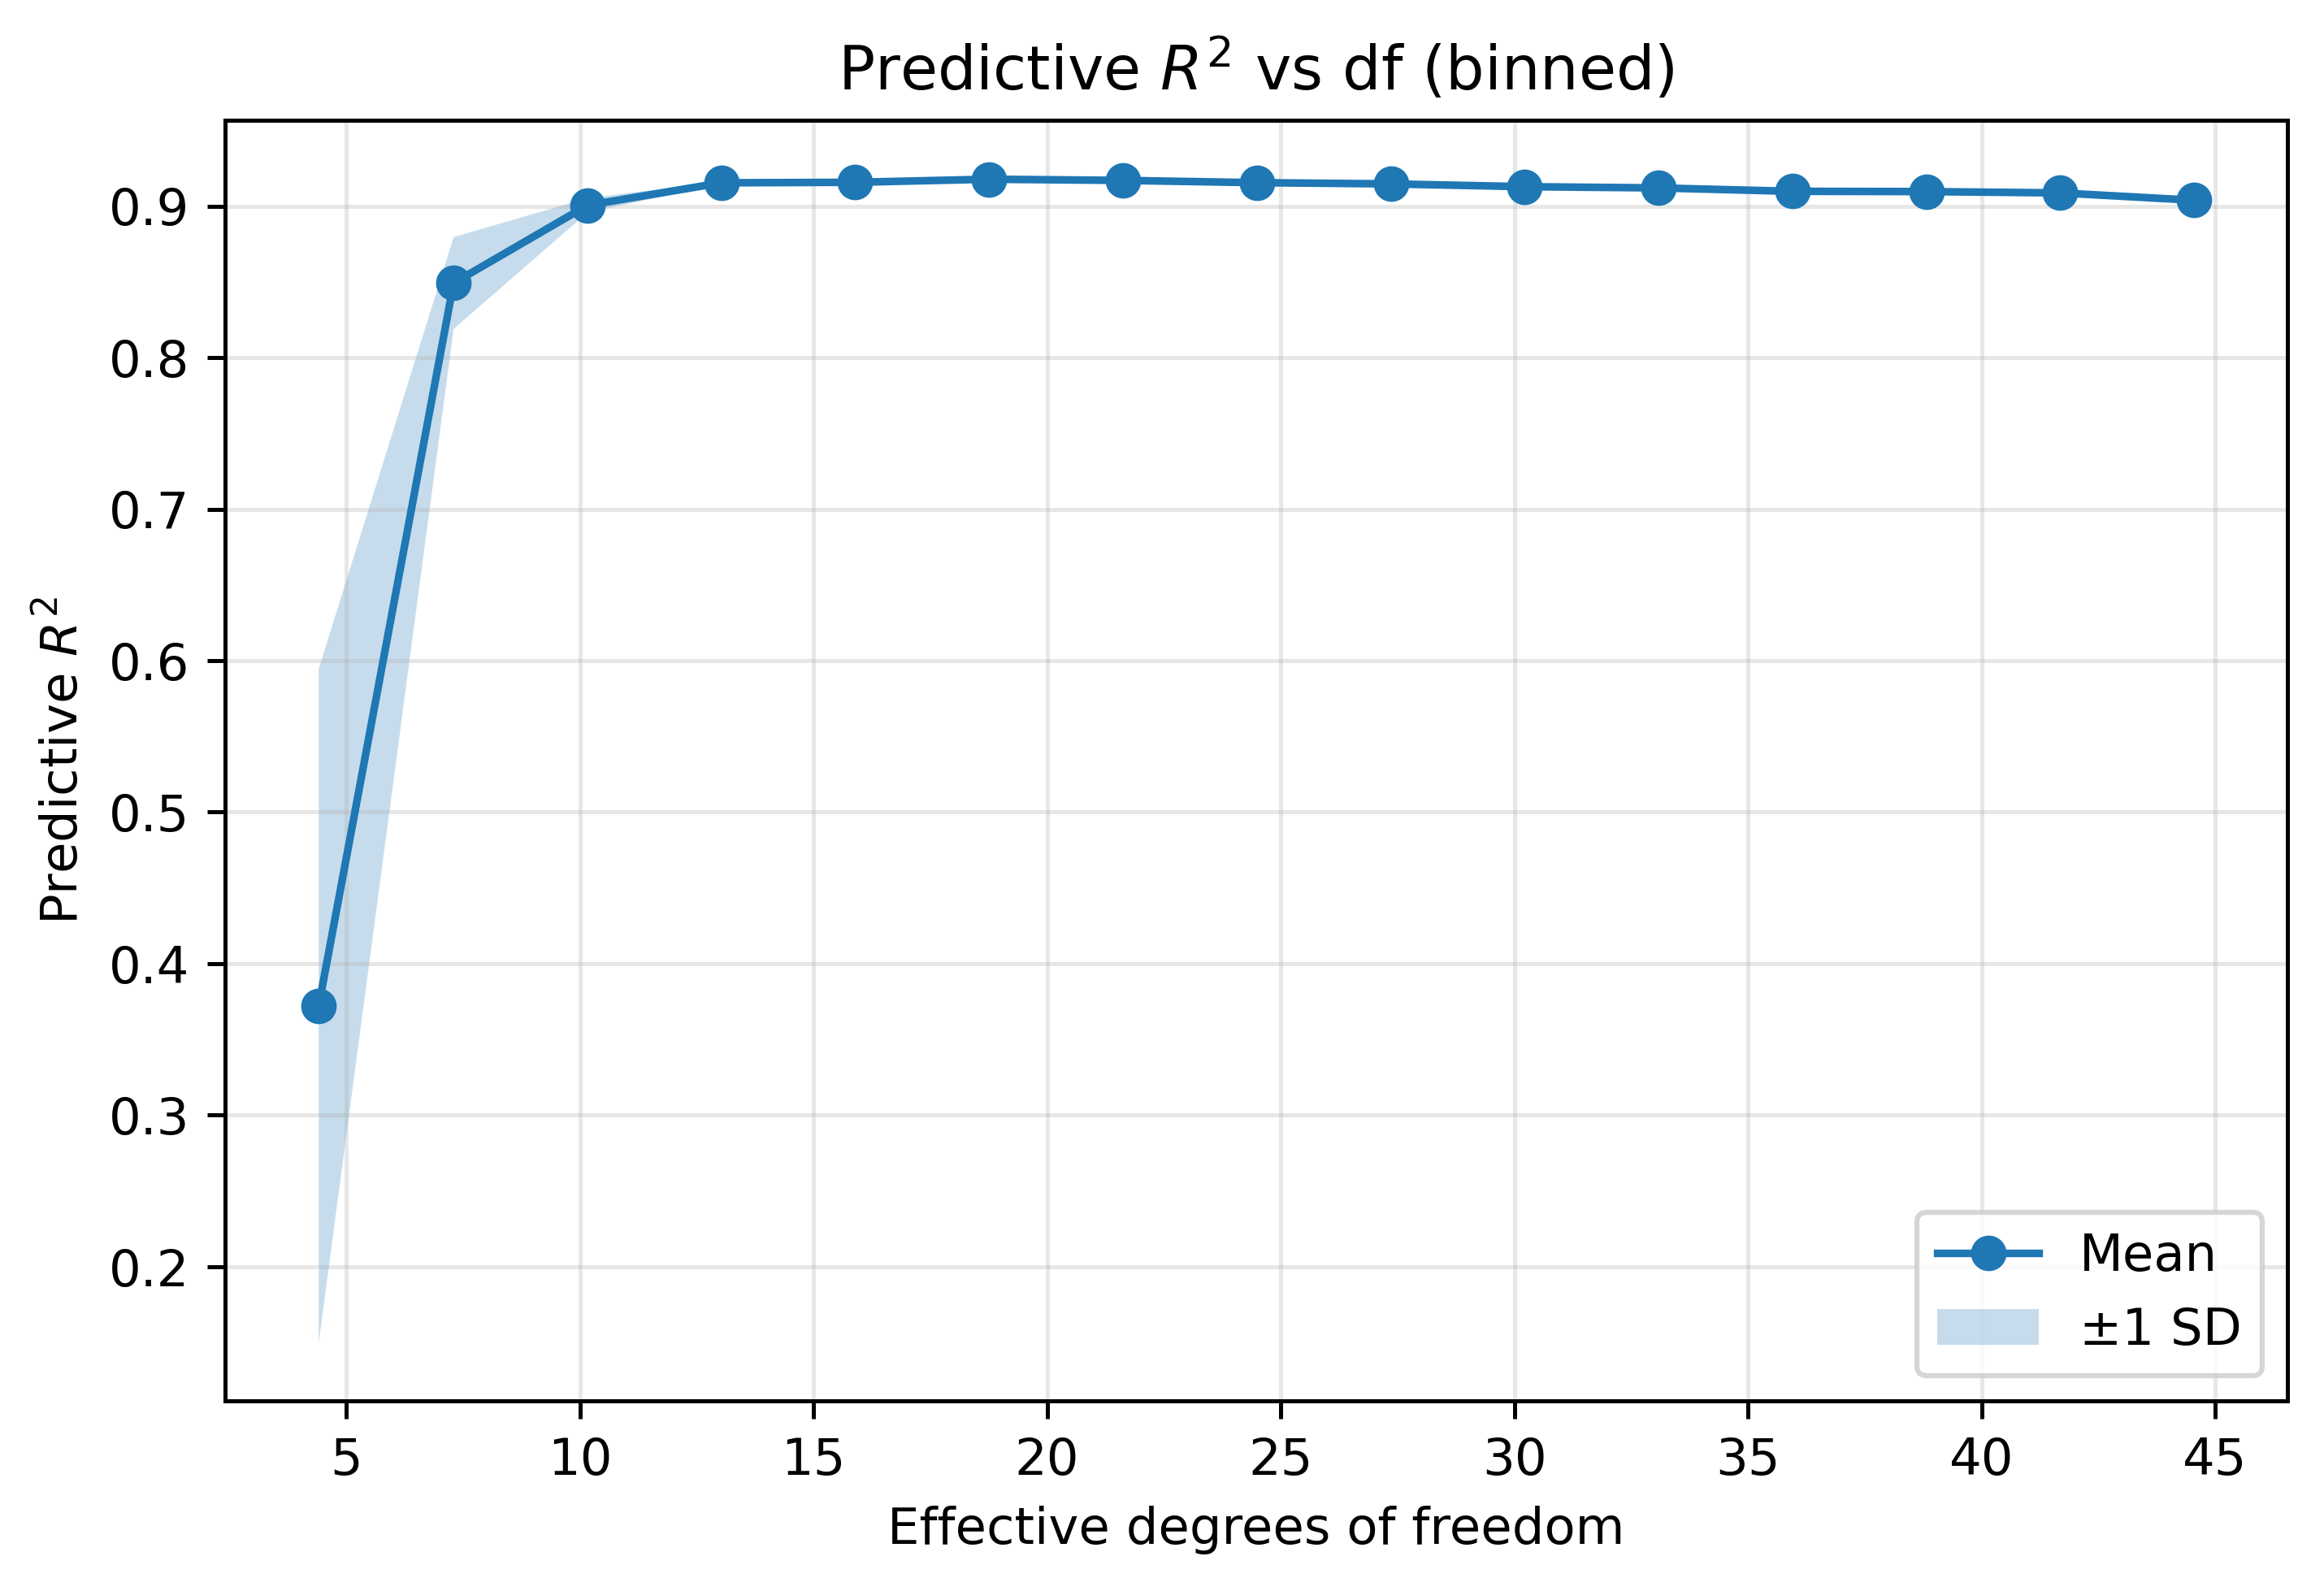

In [22]:
Image(filename="../artifacts/04_noisy_data_005/03_flr/plots/R2_vs_df_binned.png", width=600)

This is an incredibly strong relationship! This provides great evidence that degrees of freedom are what matters for $R_{pred}^{2}$.

This concludes our analysis of different choices for hyperparameters.

## Evaluate repeated CV $R^{2}$

OLS CV R^2 mean: 0.8027
OLS CV R^2 standard deviation: 0.0674

Ridge CV R^2 mean: 0.8865
Ridge CV R^2 standard deviation: 0.0437

FLR CV R^2 mean: 0.9087
FLR CV R^2 standard deviation: 0.0294


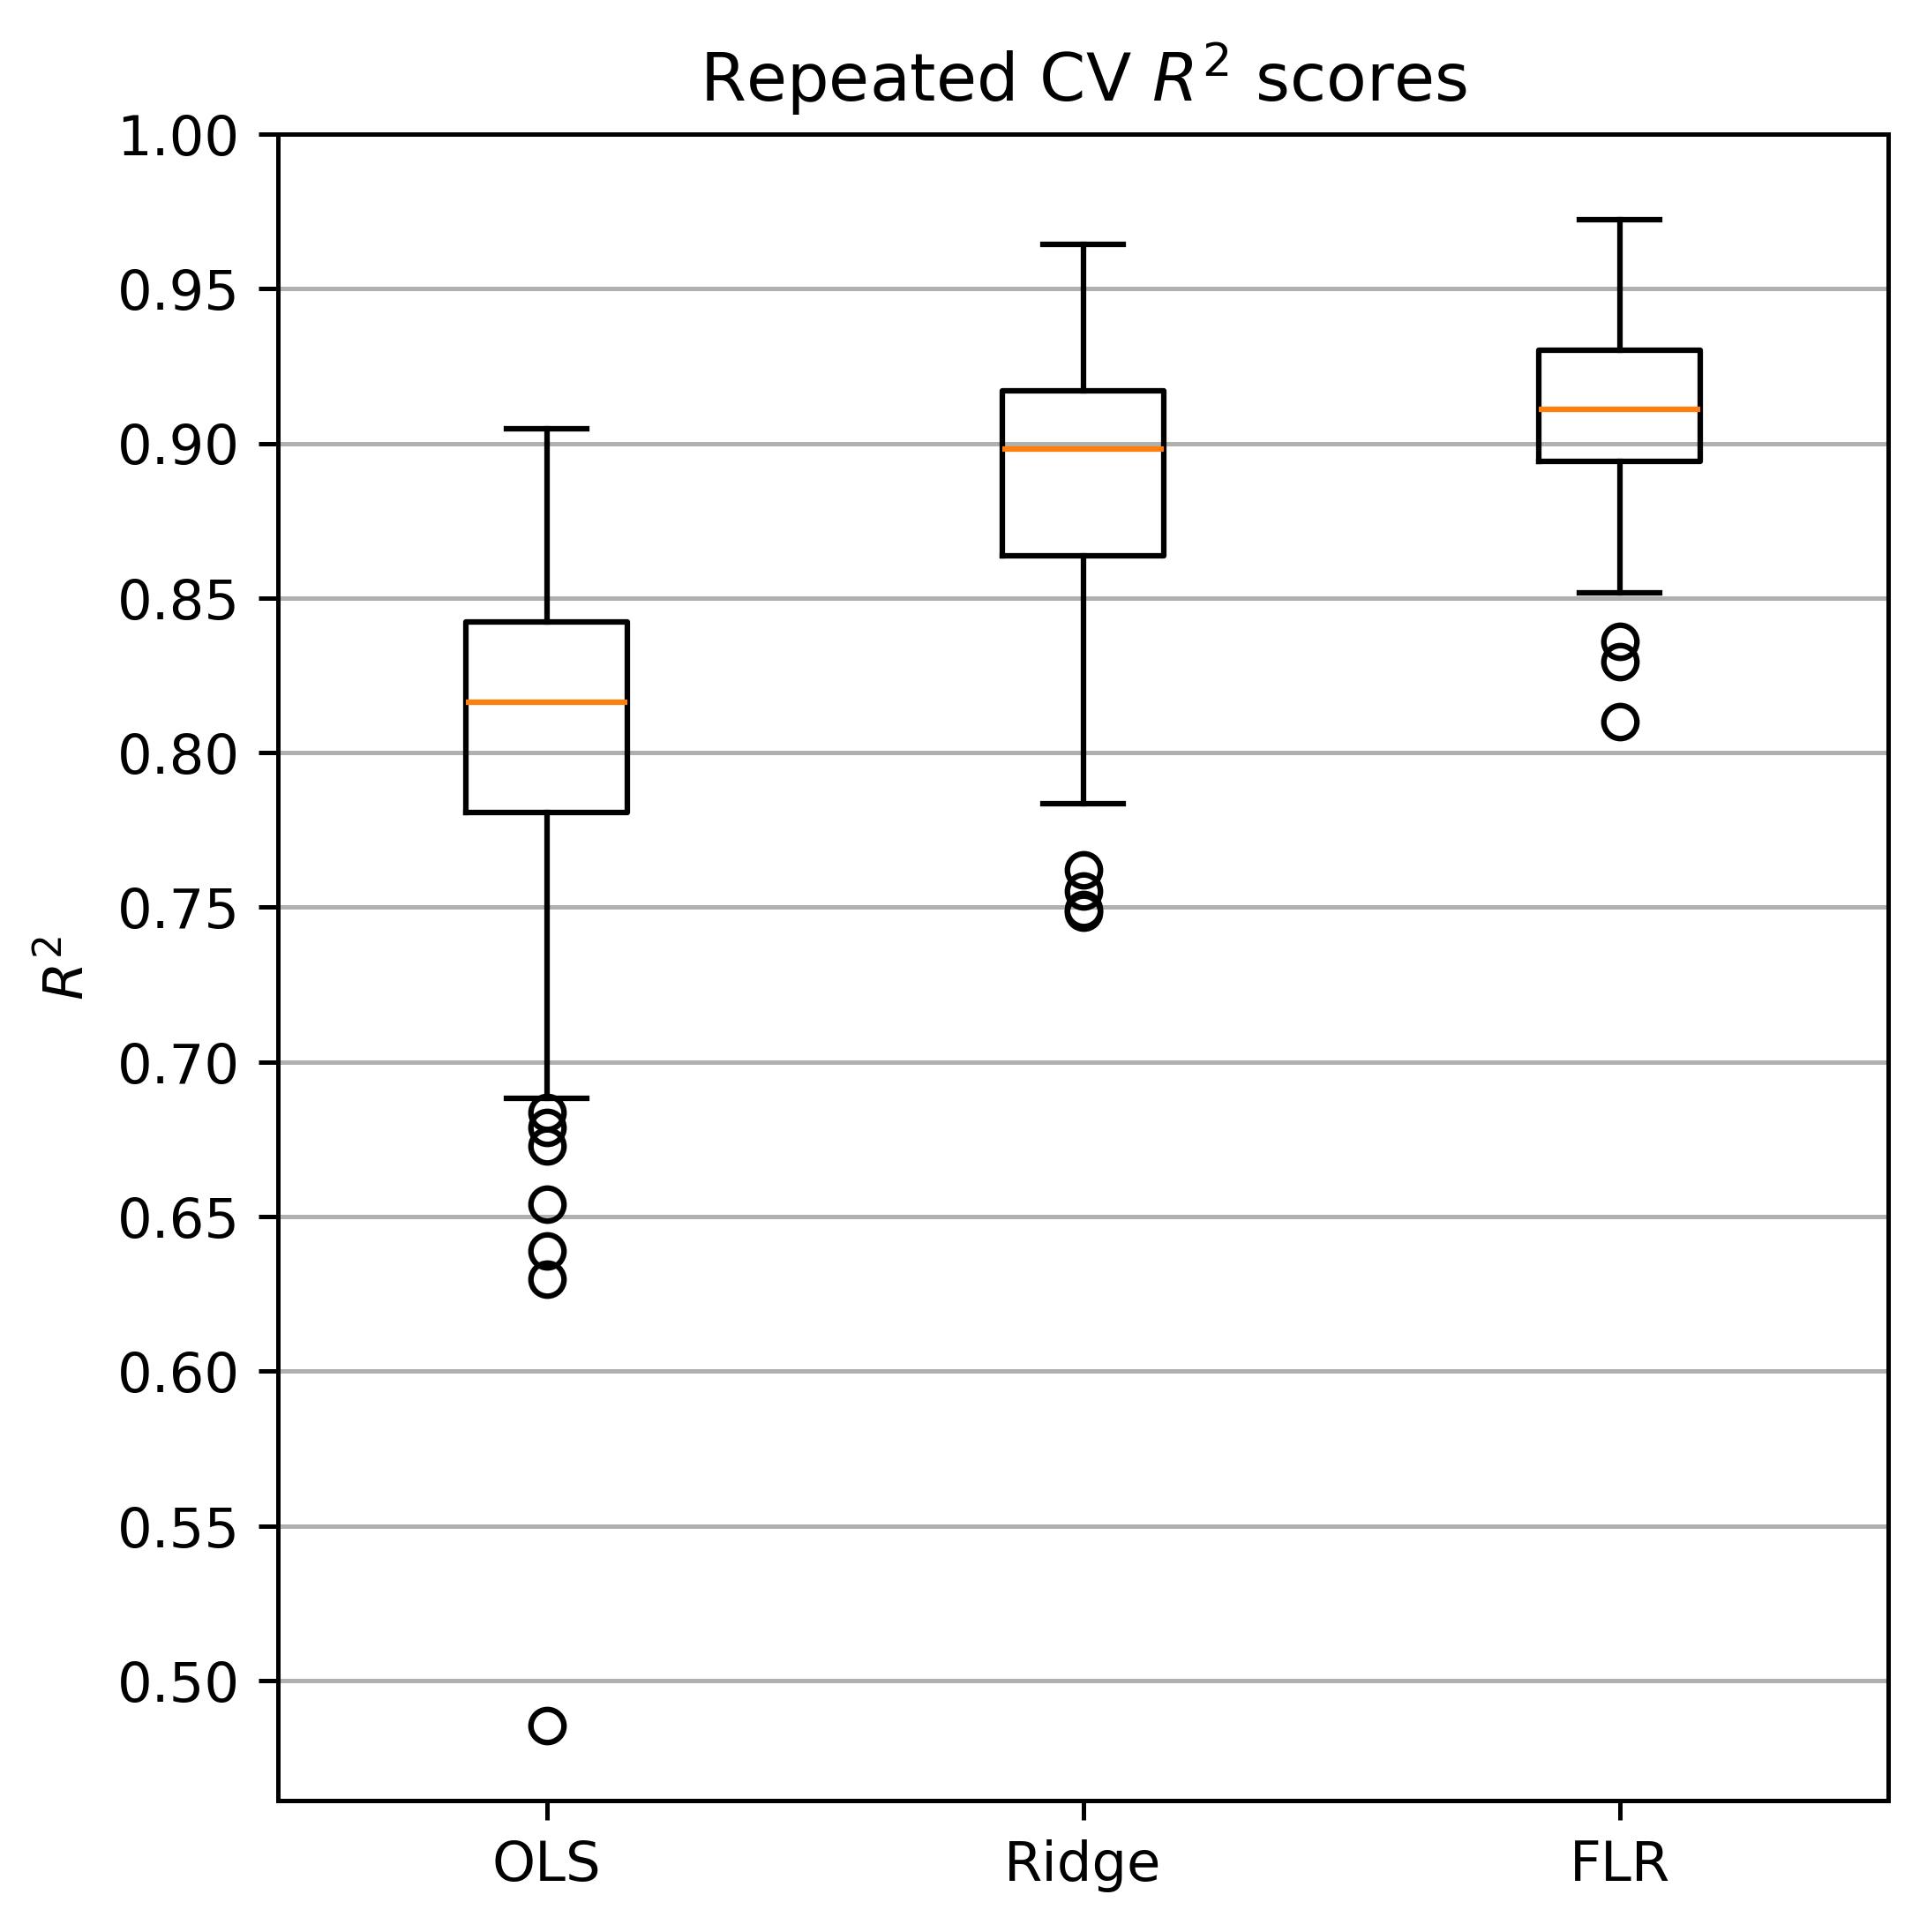

In [24]:
# Load the R^2 scores for OLS, Ridge, and FLR.
with open(str((Path(os.getcwd()).parent / "artifacts" / "04_noisy_data_005" / "01_ols" / "results" / "ols_cv.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    ols_cv_scores = pickle.load(f).r2_scores

with open(str((Path(os.getcwd()).parent / "artifacts" / "04_noisy_data_005" / "02_ridge" / "repeated_cv_results" / "results.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    ridge_cv_scores = pickle.load(f)

with open(str((Path(os.getcwd()).parent / "artifacts" / "04_noisy_data_005" / "03_flr" / "repeated_cv_results" / "results.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    flr_cv_scores = pickle.load(f)

print("OLS CV R^2 mean:", round(ols_cv_scores.mean(), 4))
print("OLS CV R^2 standard deviation:", round(ols_cv_scores.std(), 4))
print()
print("Ridge CV R^2 mean:", round(ridge_cv_scores.mean(), 4))
print("Ridge CV R^2 standard deviation:", round(ridge_cv_scores.std(), 4))
print()
print("FLR CV R^2 mean:", round(flr_cv_scores["r2_scores"].mean(), 4))
print("FLR CV R^2 standard deviation:", round(flr_cv_scores["r2_scores"].std(), 4))

Image(filename="../artifacts/04_noisy_data_005/03_flr/plots/comparison.png", width=400)

## Generate less noisy data ($\alpha = 0.02$)

In [25]:
project_root = Path.cwd().resolve().parent
original_data_directory = project_root / "data" / "original"
noisy_data_directory = project_root / "data" / "04_noisy_002"

noisy_data = generate_and_load_tecator_data_iid_noise(
    original_data_location=original_data_directory,
    new_data_location=noisy_data_directory,
    alpha=0.02,
    random_seed=0,
)

### Run 3 scripts on the noisy data

In [26]:
# Define the data directory to save to.
artifacts_location_directory = project_root / "artifacts" / "04_noisy_data_002"
output_directory_1 = artifacts_location_directory / "01_ols"
output_directory_2 = artifacts_location_directory / "02_ridge"
output_directory_3 = artifacts_location_directory / "03_flr"

# Define the data directories to read from.
data_location_directory = noisy_data_directory

%run ../scripts/01_ols.py --out-dir "{output_directory_1}" --data-location-directory "{noisy_data_directory}"
%run ../scripts/02_ridge.py --out-dir "{output_directory_2}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"
%run ../scripts/03_flr.py --out-dir "{output_directory_3}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"

162/1620 runs (10%) | elapsed 5.9s
324/1620 runs (20%) | elapsed 10.8s
486/1620 runs (30%) | elapsed 16.4s
648/1620 runs (40%) | elapsed 23.7s
810/1620 runs (50%) | elapsed 30.9s
972/1620 runs (60%) | elapsed 40.1s
1134/1620 runs (70%) | elapsed 47.6s
1296/1620 runs (80%) | elapsed 56.0s
1458/1620 runs (90%) | elapsed 67.7s
1620/1620 runs (100%) | elapsed 80.3s
Done with analysis plot generation! Proceding to repeated CV.


### Visualize the first 5 wavelength spectra with the mean functional

In [27]:
tecator_df, fat_df, wavelength_grid, wavelength_unit = load_tecator_fat(location=data_location_directory)

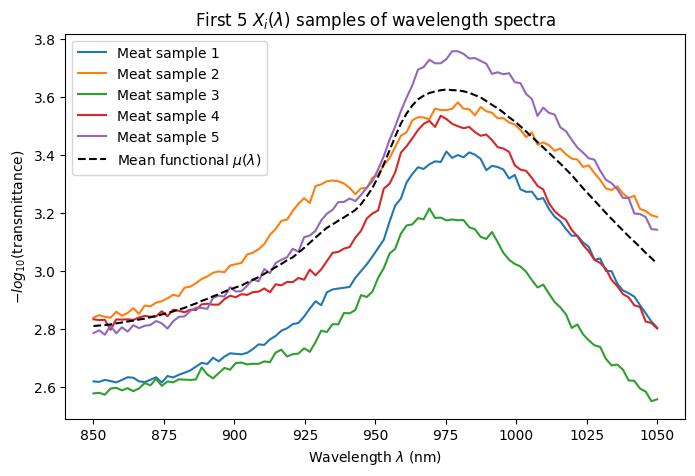

In [28]:
plt.figure(figsize=(8,5))

for i in range(5):
    plt.plot(wavelength_grid, tecator_df.iloc[i], label=f"Meat sample {i+1}")

plt.plot(wavelength_grid, tecator_df.mean(axis=0), linestyle="--", c="black", label=r"Mean functional $\mu(\lambda)$")

plt.title(r"First 5 $X_{i}(\lambda)$ samples of wavelength spectra")
plt.xlabel(rf"Wavelength $\lambda$ ({wavelength_unit})")
plt.ylabel(r"$-log_{10}(\text{transmittance})$")
plt.legend()
plt.show()

### Evaluate repeated CV $R^{2}$

OLS CV R^2 mean: 0.8525
OLS CV R^2 standard deviation: 0.0439

Ridge CV R^2 mean: 0.9256
Ridge CV R^2 standard deviation: 0.022

FLR CV R^2 mean: 0.9348
FLR CV R^2 standard deviation: 0.019


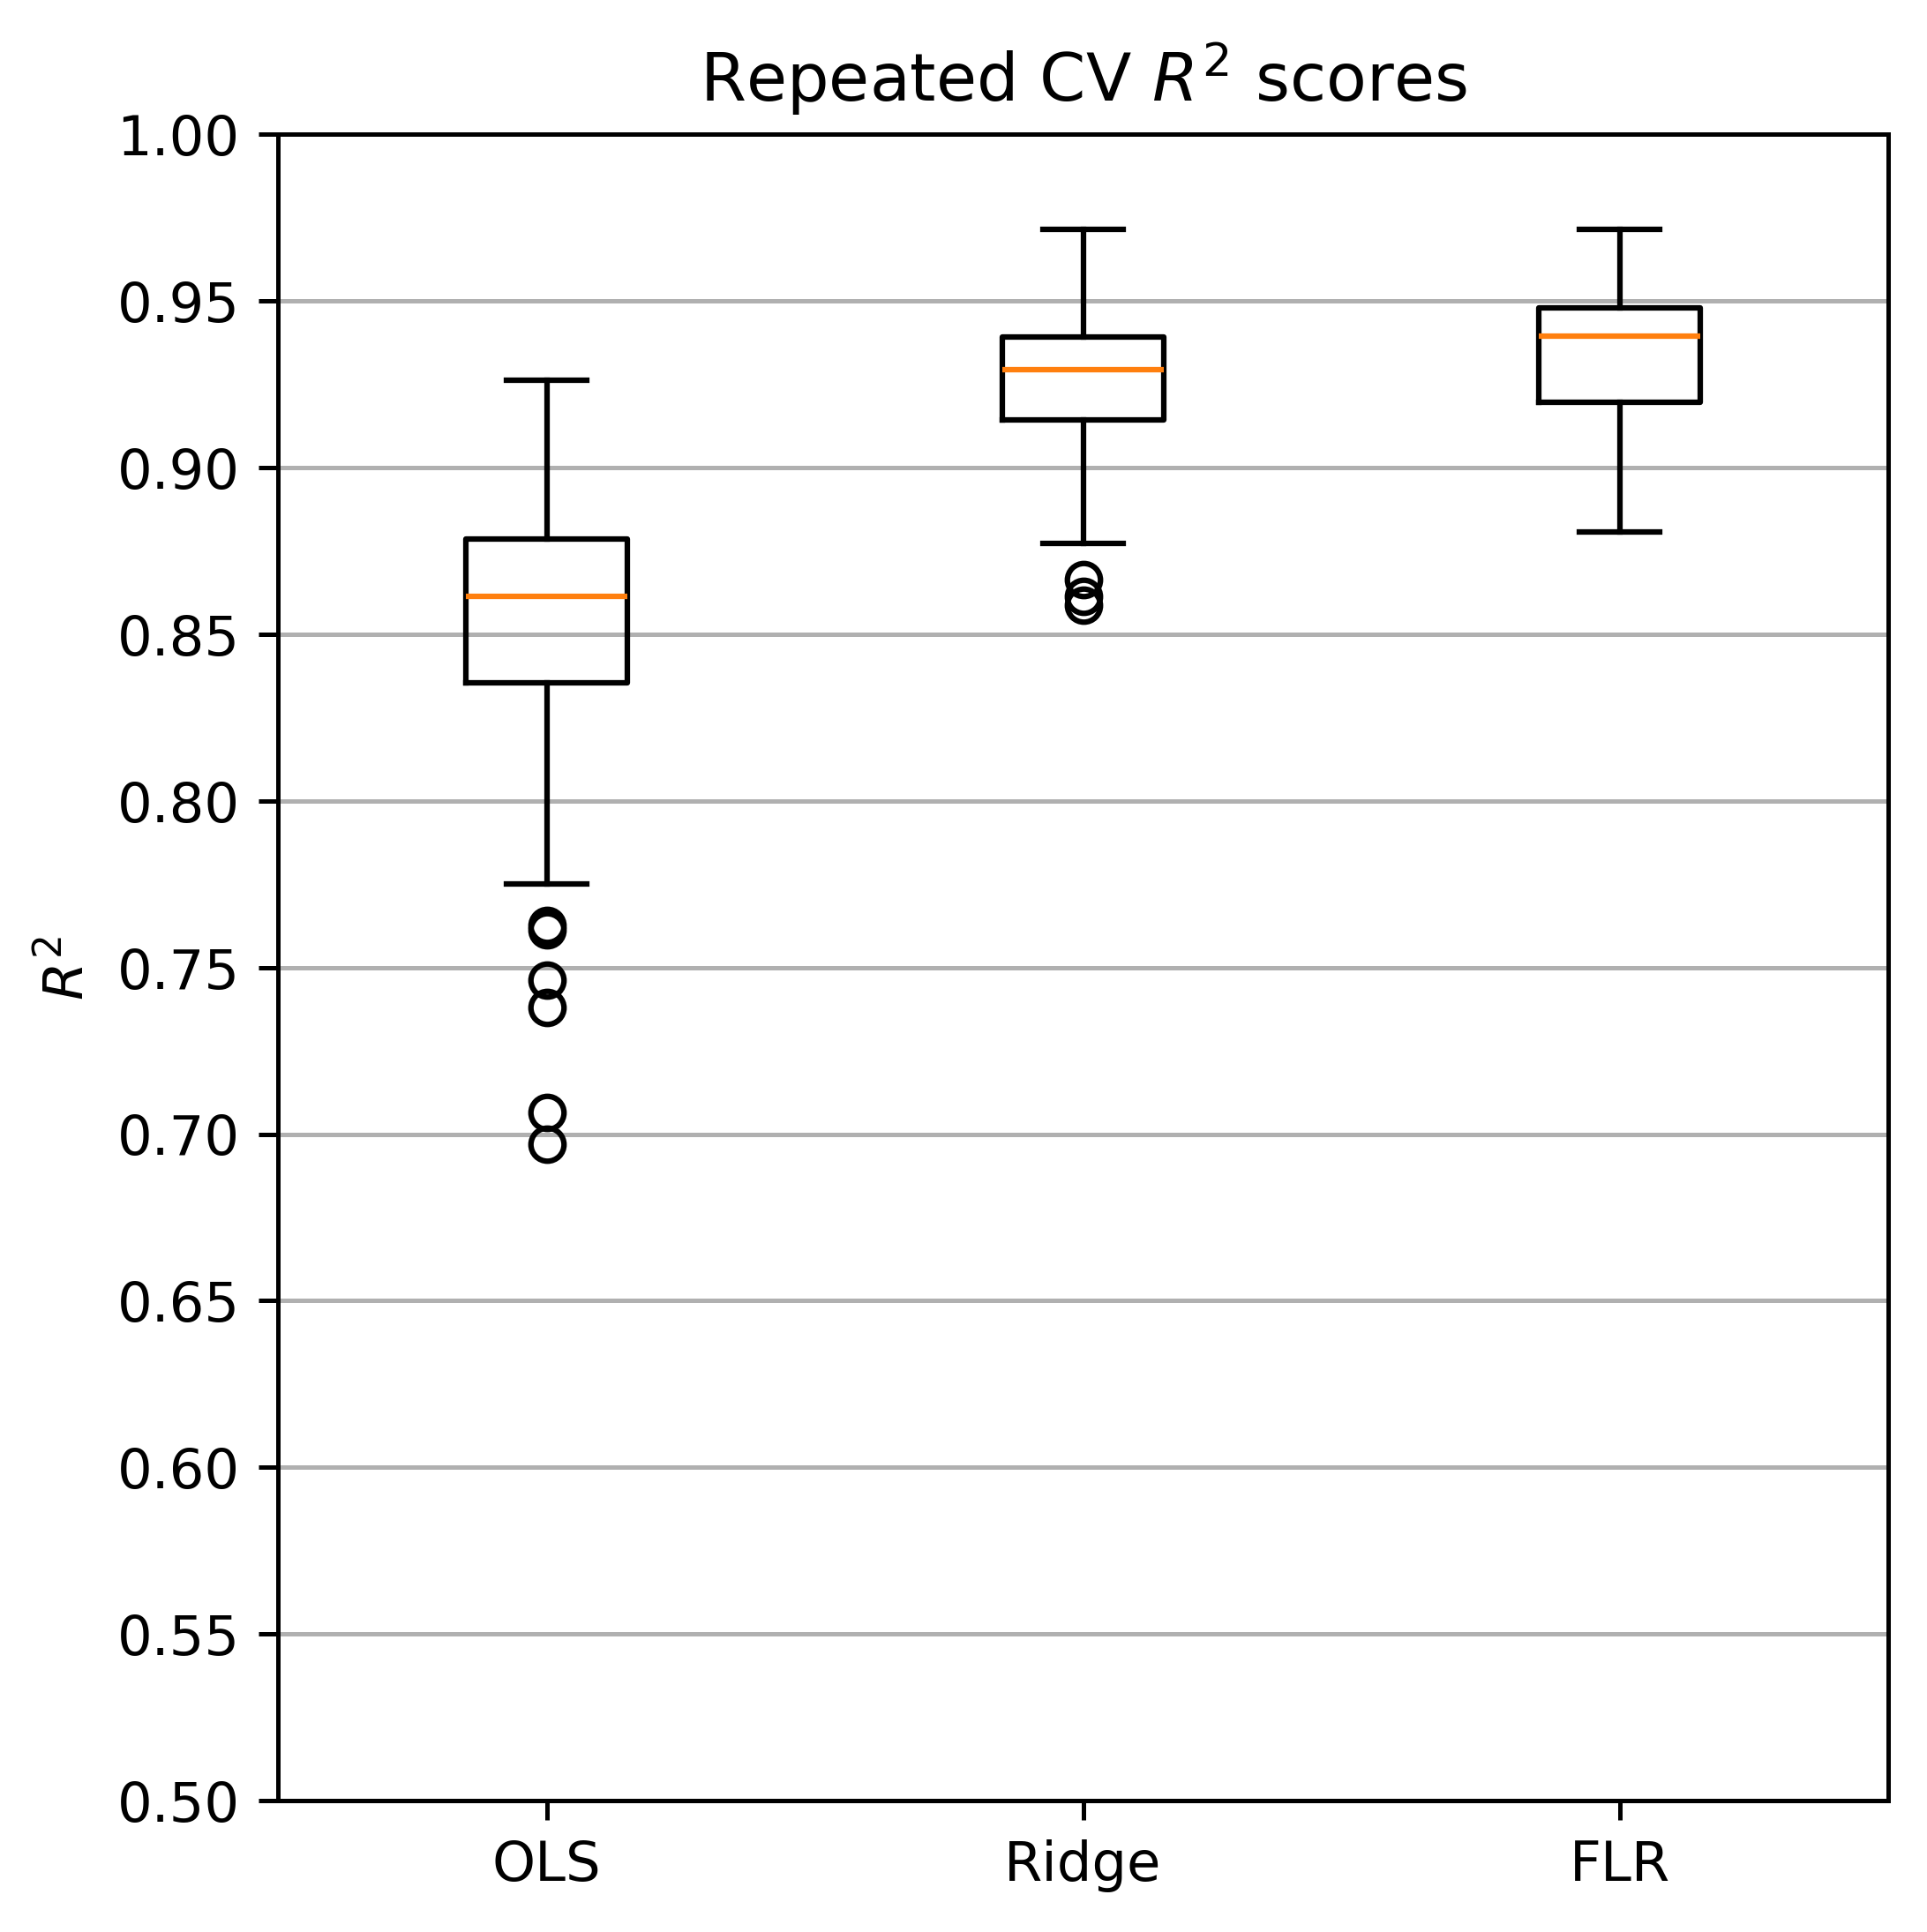

In [29]:
# Load the R^2 scores for OLS, Ridge, and FLR.
with open(str((Path(os.getcwd()).parent / "artifacts" / "04_noisy_data_002" / "01_ols" / "results" / "ols_cv.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    ols_cv_scores = pickle.load(f).r2_scores

with open(str((Path(os.getcwd()).parent / "artifacts" / "04_noisy_data_002" / "02_ridge" / "repeated_cv_results" / "results.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    ridge_cv_scores = pickle.load(f)

with open(str((Path(os.getcwd()).parent / "artifacts" / "04_noisy_data_002" / "03_flr" / "repeated_cv_results" / "results.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    flr_cv_scores = pickle.load(f)

print("OLS CV R^2 mean:", round(ols_cv_scores.mean(), 4))
print("OLS CV R^2 standard deviation:", round(ols_cv_scores.std(), 4))
print()
print("Ridge CV R^2 mean:", round(ridge_cv_scores.mean(), 4))
print("Ridge CV R^2 standard deviation:", round(ridge_cv_scores.std(), 4))
print()
print("FLR CV R^2 mean:", round(flr_cv_scores["r2_scores"].mean(), 4))
print("FLR CV R^2 standard deviation:", round(flr_cv_scores["r2_scores"].std(), 4))

Image(filename="../artifacts/04_noisy_data_002/03_flr/plots/comparison.png", width=400)

## Generate noisier data ($\alpha = 0.2$)

In [30]:
project_root = Path.cwd().resolve().parent
original_data_directory = project_root / "data" / "original"
noisy_data_directory = project_root / "data" / "04_noisy_02"

noisy_data = generate_and_load_tecator_data_iid_noise(
    original_data_location=original_data_directory,
    new_data_location=noisy_data_directory,
    alpha=0.2,
    random_seed=0,
)

### Run 3 scripts on the noisy data

In [31]:
# Define the data directory to save to.
artifacts_location_directory = project_root / "artifacts" / "04_noisy_data_02"
output_directory_1 = artifacts_location_directory / "01_ols"
output_directory_2 = artifacts_location_directory / "02_ridge"
output_directory_3 = artifacts_location_directory / "03_flr"

# Define the data directories to read from.
data_location_directory = noisy_data_directory

%run ../scripts/01_ols.py --out-dir "{output_directory_1}" --data-location-directory "{noisy_data_directory}"
%run ../scripts/02_ridge.py --out-dir "{output_directory_2}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"
%run ../scripts/03_flr.py --out-dir "{output_directory_3}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"

162/1620 runs (10%) | elapsed 5.9s
324/1620 runs (20%) | elapsed 11.0s
486/1620 runs (30%) | elapsed 16.6s
648/1620 runs (40%) | elapsed 23.8s
810/1620 runs (50%) | elapsed 31.1s
972/1620 runs (60%) | elapsed 40.3s
1134/1620 runs (70%) | elapsed 47.7s
1296/1620 runs (80%) | elapsed 56.1s
1458/1620 runs (90%) | elapsed 67.6s
1620/1620 runs (100%) | elapsed 80.2s
Done with analysis plot generation! Proceding to repeated CV.


### Visualize the first 5 wavelength spectra with the mean functional

In [32]:
tecator_df, fat_df, wavelength_grid, wavelength_unit = load_tecator_fat(location=data_location_directory)

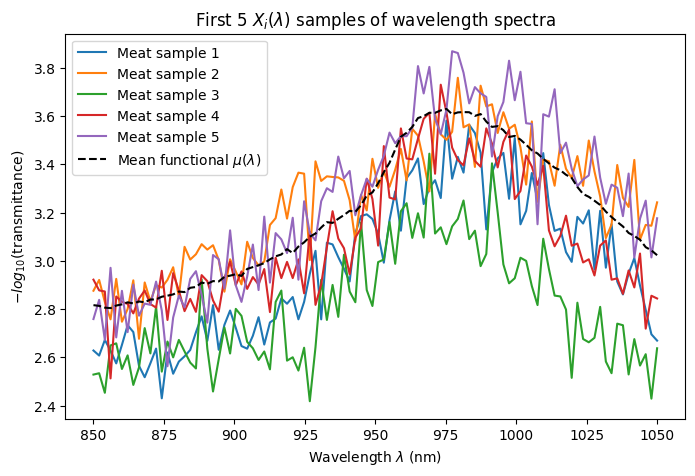

In [33]:
plt.figure(figsize=(8,5))

for i in range(5):
    plt.plot(wavelength_grid, tecator_df.iloc[i], label=f"Meat sample {i+1}")

plt.plot(wavelength_grid, tecator_df.mean(axis=0), linestyle="--", c="black", label=r"Mean functional $\mu(\lambda)$")

plt.title(r"First 5 $X_{i}(\lambda)$ samples of wavelength spectra")
plt.xlabel(rf"Wavelength $\lambda$ ({wavelength_unit})")
plt.ylabel(r"$-log_{10}(\text{transmittance})$")
plt.legend()
plt.show()

### Evaluate repeated CV $R^{2}$

OLS CV R^2 mean: 0.457
OLS CV R^2 standard deviation: 0.2309

Ridge CV R^2 mean: 0.6762
Ridge CV R^2 standard deviation: 0.1376

FLR CV R^2 mean: 0.7267
FLR CV R^2 standard deviation: 0.1245


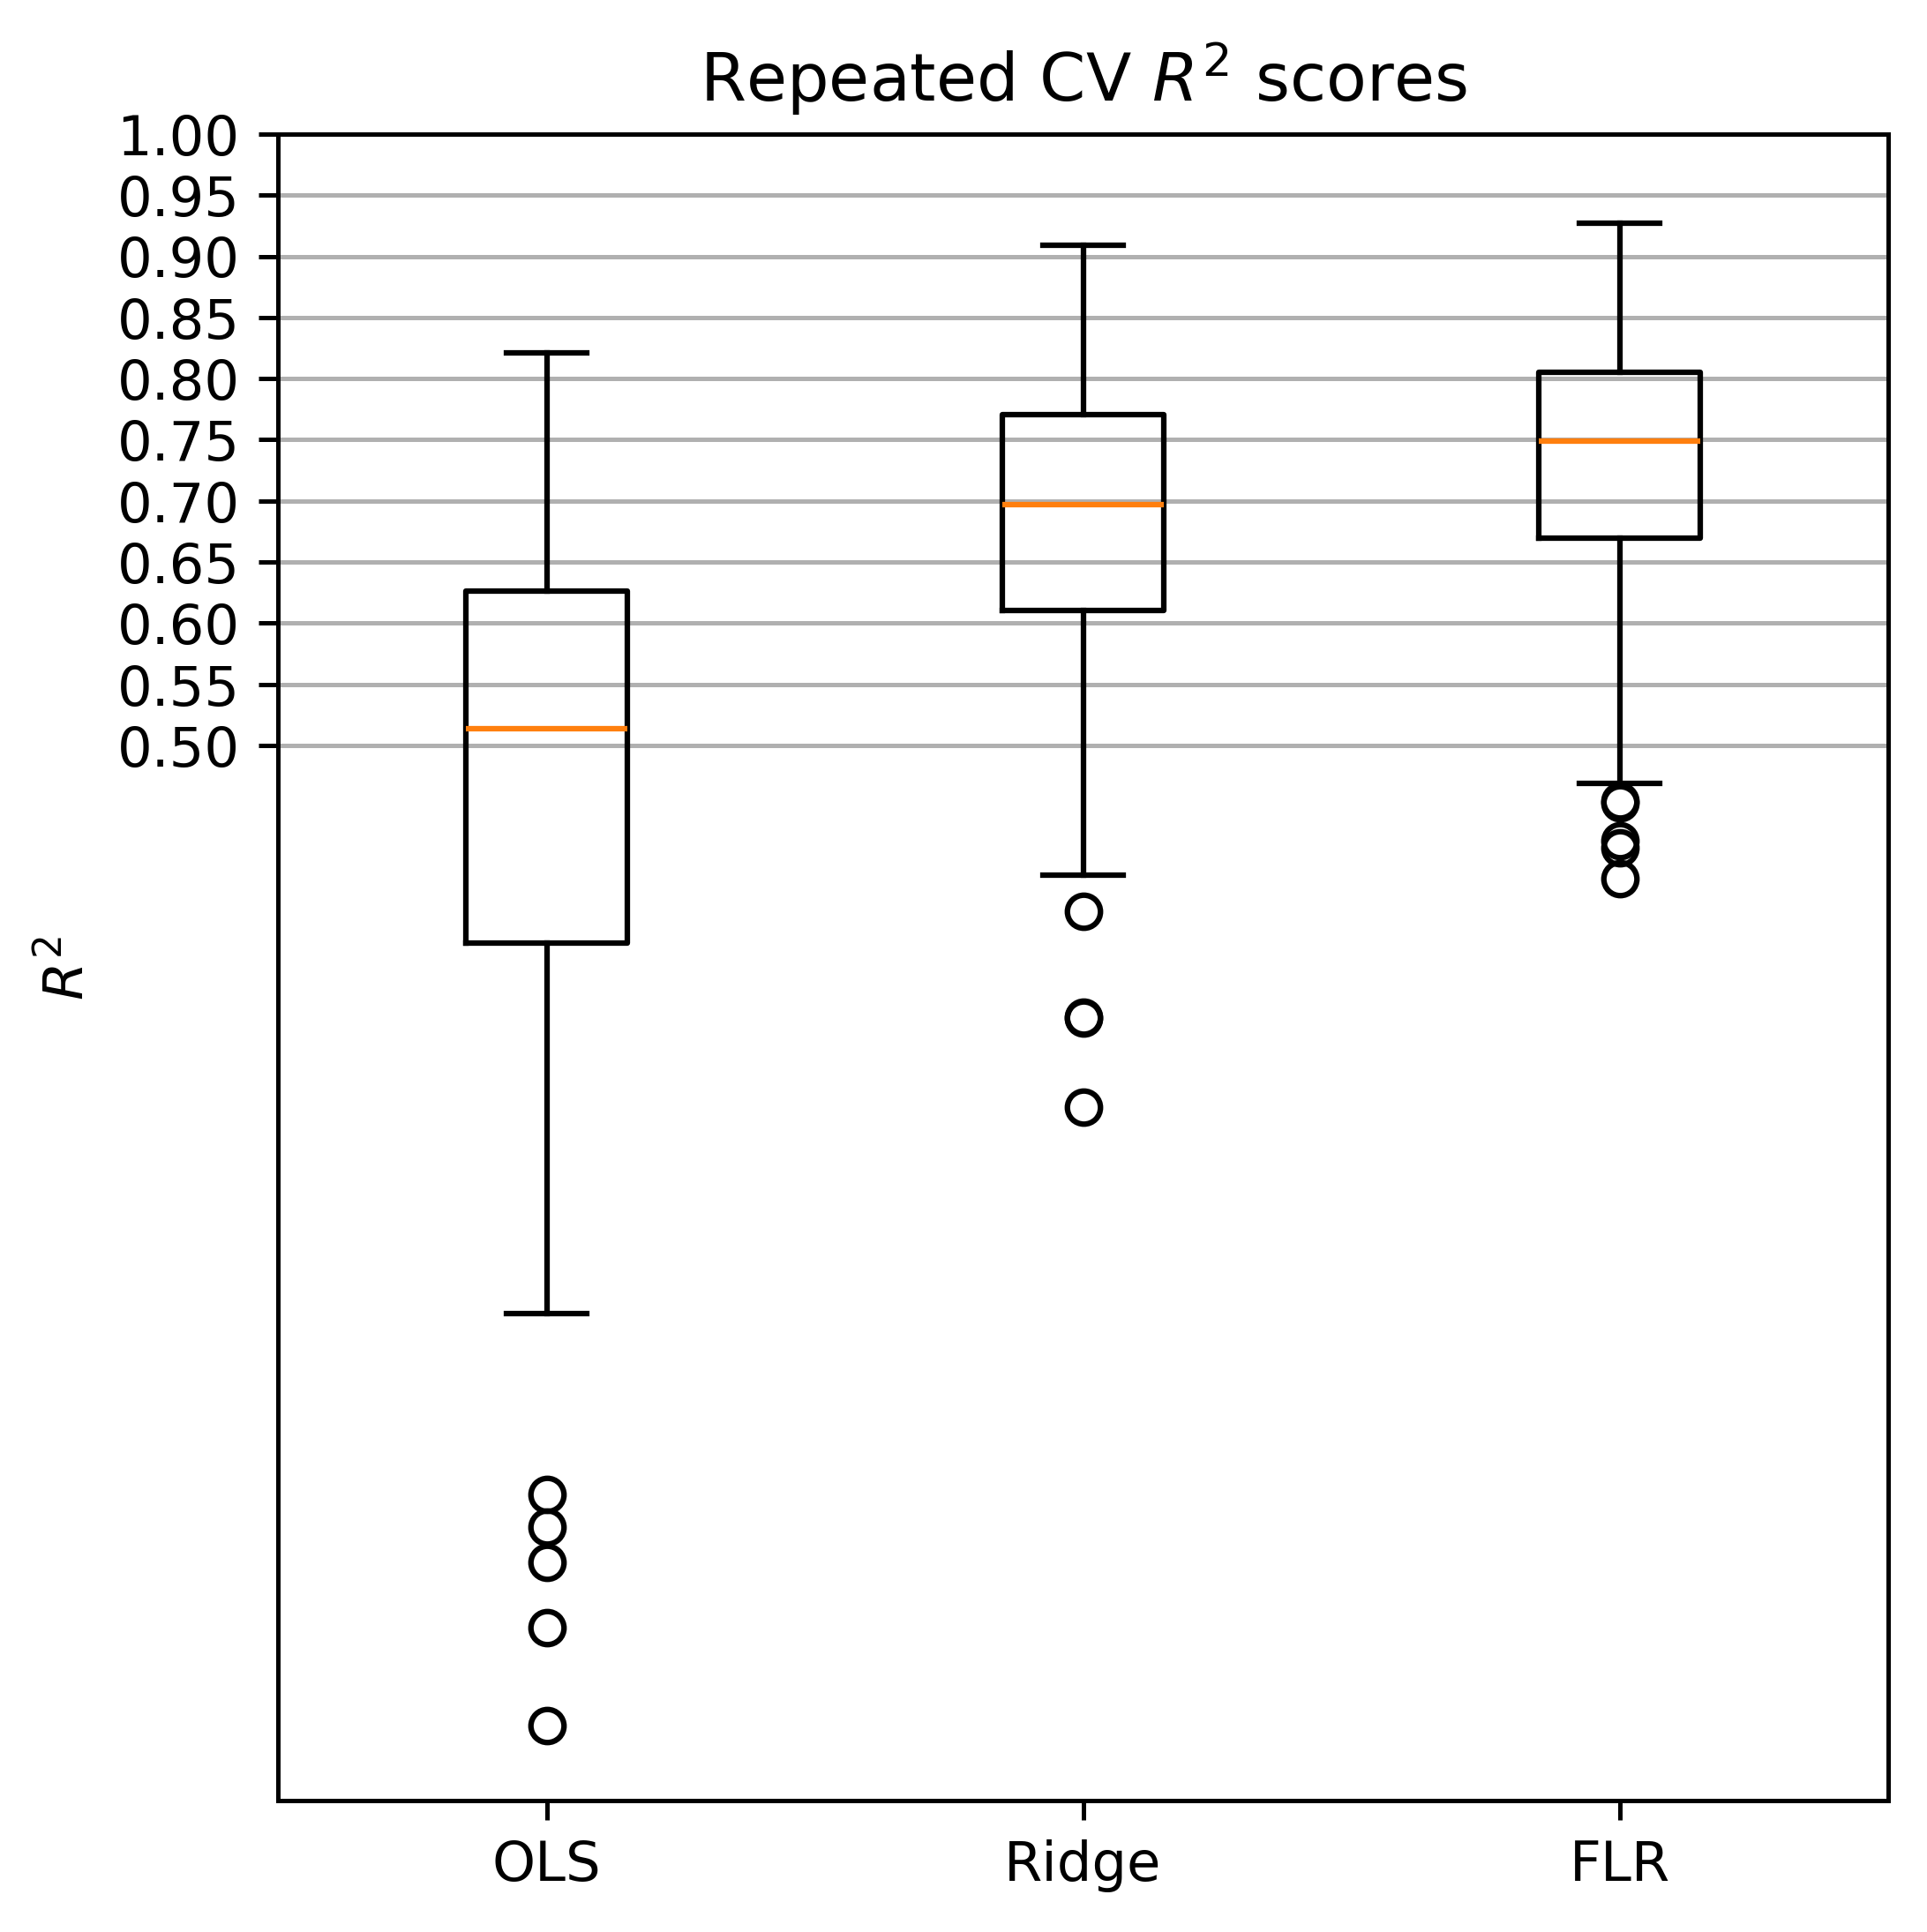

In [34]:
# Load the R^2 scores for OLS, Ridge, and FLR.
with open(str((Path(os.getcwd()).parent / "artifacts" / "04_noisy_data_02" / "01_ols" / "results" / "ols_cv.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    ols_cv_scores = pickle.load(f).r2_scores

with open(str((Path(os.getcwd()).parent / "artifacts" / "04_noisy_data_02" / "02_ridge" / "repeated_cv_results" / "results.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    ridge_cv_scores = pickle.load(f)

with open(str((Path(os.getcwd()).parent / "artifacts" / "04_noisy_data_02" / "03_flr" / "repeated_cv_results" / "results.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    flr_cv_scores = pickle.load(f)

print("OLS CV R^2 mean:", round(ols_cv_scores.mean(), 4))
print("OLS CV R^2 standard deviation:", round(ols_cv_scores.std(), 4))
print()
print("Ridge CV R^2 mean:", round(ridge_cv_scores.mean(), 4))
print("Ridge CV R^2 standard deviation:", round(ridge_cv_scores.std(), 4))
print()
print("FLR CV R^2 mean:", round(flr_cv_scores["r2_scores"].mean(), 4))
print("FLR CV R^2 standard deviation:", round(flr_cv_scores["r2_scores"].std(), 4))

Image(filename="../artifacts/04_noisy_data_02/03_flr/plots/comparison.png", width=400)